# Nhập thư viện


In [ ]:
import os, time, math, random, requests
import pandas as pd
from datetime import datetime, timezone, timedelta
from tqdm import tqdm
from pytrends.request import TrendReq
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Lấy và xử lý dữ liệu

## Lấy file dữ liệu BTC


In [16]:
# Cell 1️⃣: Import & cấu hình cơ bản (phiên bản cố định, không cần nhập)
# -----------------------
# CONFIG CỐ ĐỊNH
# -----------------------

# Dữ liệu coin bạn muốn lấy
SYMBOL_BASE = "BTC"             # ví dụ: "BTC", "ETH", "BNB", "SOL", "XRP"
SYMBOL_BINANCE = SYMBOL_BASE + "USDT"   # tự tạo mã Binance Futures

# Thông tin thời gian
INTERVAL = "1d"                 # khung thời gian: "1d", "1h", ...
START_DATE = "2023-01-01"       # ngày bắt đầu
END_DATE = "2025-08-01"         # ngày kết thúc

# Thư mục lưu dữ liệu
OUT_DIR = os.path.join("data", SYMBOL_BASE)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"✅ Đang lấy dữ liệu cho {SYMBOL_BASE} ({SYMBOL_BINANCE}) từ {START_DATE} → {END_DATE}, interval={INTERVAL}")

✅ Đang lấy dữ liệu cho BTC (BTCUSDT) từ 2023-01-01 → 2025-08-01, interval=1d


In [17]:
# Cell 2️⃣: Hàm xử lý thời gian (convert timestamp <-> datetime)

def dt_to_millis(dt: datetime):
    return int(dt.replace(tzinfo=timezone.utc).timestamp() * 1000)

def date_to_millis(s):
    dt = datetime.fromisoformat(s)
    return dt_to_millis(dt)

def millis_to_date(millis):
    return datetime.fromtimestamp(millis/1000, tz=timezone.utc).date()


In [18]:
def fetch_binance_klines(symbol, interval, start_ts_ms, end_ts_ms):
    """
    Lấy dữ liệu OHLC từ Binance Futures (fallback sang Spot nếu bị chặn 418)
    """
    futures_url = "https://fapi.binance.com/fapi/v1/klines"
    spot_url = "https://api.binance.com/api/v3/klines"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    limit = 1000
    all_klines = []
    start = start_ts_ms
    use_spot = False

    while True:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start,
            "endTime": end_ts_ms,
            "limit": limit
        }

        # chọn API phù hợp
        url = spot_url if use_spot else futures_url
        try:
            r = requests.get(url, params=params, headers=headers, timeout=30)
            if r.status_code == 418:
                print(f"[WARN] Binance Futures chặn IP (418) → chuyển sang Spot API.")
                use_spot = True
                continue
            r.raise_for_status()
            data = r.json()
        except requests.exceptions.HTTPError as e:
            print(f"[ERROR] {e}")
            break
        except Exception as e:
            print(f"[WARN] Network error: {e}")
            time.sleep(5)
            continue

        if not data:
            break

        all_klines.extend(data)
        if len(data) < limit:
            break
        last_open = data[-1][0]
        start = last_open + 1
        time.sleep(0.2)

    # Chuyển sang DataFrame
    if not all_klines:
        print("[WARN] Không lấy được dữ liệu Klines.")
        return pd.DataFrame(columns=["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades","symbol"])

    cols = ["open_time","open","high","low","close","volume","close_time",
            "quote_asset_volume","num_trades","taker_buy_base_vol","taker_buy_quote_vol","ignore"]

    df = pd.DataFrame(all_klines, columns=cols)
    df["Date"] = pd.to_datetime(df["open_time"], unit="ms", utc=True).dt.date
    df = df[["Date","open","high","low","close","volume","quote_asset_volume","num_trades"]]
    df.columns = ["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]
    for c in ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["symbol"] = SYMBOL_BASE
    df = df.sort_values("Date").drop_duplicates("Date").reset_index(drop=True)

    print(f"✅ Dữ liệu Binance ({'Spot' if use_spot else 'Futures'}) tải thành công: {len(df)} dòng")
    return df


In [19]:
# Cell 4️⃣: Funding Rate trung bình theo ngày (Binance Futures)

def fetch_binance_funding(symbol, start_ts_ms, end_ts_ms):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    limit = 1000
    all_rows = []
    start = start_ts_ms

    while True:
        params = {"symbol": symbol, "startTime": start, "endTime": end_ts_ms, "limit": limit}
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        if not data:
            break

        all_rows.extend(data)
        if len(data) < limit:
            break

        last_t = data[-1]["fundingTime"]
        start = last_t + 1
        time.sleep(0.2)

    if not all_rows:
        return pd.DataFrame(columns=["Date","funding_Rate"])

    df = pd.DataFrame(all_rows)
    df["fundingTime"] = pd.to_datetime(df["fundingTime"], unit="ms", utc=True)
    df["Date"] = df["fundingTime"].dt.date
    df["fundingRate"] = pd.to_numeric(df["fundingRate"], errors="coerce")
    daily = df.groupby("Date", as_index=False)["fundingRate"].mean().rename(columns={"fundingRate":"funding_Rate"})
    return daily

In [20]:
# Cell 5️⃣: Lấy Fear & Greed Index (Alternative.me API) — phiên bản ổn định nhất

def fetch_fear_greed(limit=0):
    """
    Lấy dữ liệu Fear & Greed Index từ API alternative.me
    Trả về DataFrame có cột: Date, fetch_fear_greed
    """
    url = "https://api.alternative.me/fng/"
    params = {"limit": limit, "format": "json"}  # không dùng date_format vì không cần thiết

    try:
        r = requests.get(url, params=params, timeout=15)
        r.raise_for_status()
        j = r.json()
        data = j.get("data", [])
    except Exception as e:
        print(f"[WARN] Fear & Greed API failed: {e}")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    # Nếu rỗng, in cảnh báo
    if not data:
        print("[WARN] Fear & Greed API returned empty dataset, skipping...")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    rows = []
    for entry in data:
        try:
            ts = int(entry["timestamp"])
            value = float(entry["value"])
            date = datetime.fromtimestamp(ts, tz=timezone.utc).date()
            rows.append({"Date": date, "fetch_fear_greed": value})
        except Exception as e:
            print(f"[WARN] parse error: {e}")
            continue

    df = pd.DataFrame(rows)
    df = df.drop_duplicates("Date").sort_values("Date").reset_index(drop=True)
    print(f"✅ Fear & Greed fetched: {len(df)} rows")
    print(df.head())
    return df

In [21]:
# Cell 6️⃣: On-chain metrics (active_addresses, hash_rate, tx_count, miners_revenue)

BLOCKCHAIN_CHARTS = {
    # "active_addresses": "n-active-addresses",  # ⚠️ gỡ bỏ vì bị 404
    "hash_rate": "hash-rate",
    "tx_count": "n-transactions",
    "miners_revenue": "miners-revenue"
}


def fetch_blockchain_chart(chart_name, timespan_days=4000):
    url = f"https://api.blockchain.info/charts/{chart_name}"
    params = {"timespan": f"{timespan_days}days", "format":"json", "sampled":False}
    r = requests.get(url, params=params, timeout=30)
    if r.status_code != 200:
        r = requests.get(url, params={"timespan":f"{timespan_days}days","format":"json"}, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f"Blockchain.info chart {chart_name} returned {r.status_code}")

    j = r.json()
    values = j.get("values", [])
    rows = [{"Date": datetime.fromtimestamp(v["x"], tz=timezone.utc).date(), chart_name: v["y"]} for v in values]
    return pd.DataFrame(rows).drop_duplicates("Date").sort_values("Date").reset_index(drop=True)

def fetch_onchain_from_blockchain_info(mapping):
    dfs = []
    for outcol, chart in mapping.items():
        try:
            dfc = fetch_blockchain_chart(chart, timespan_days=5000)
            dfc = dfc.rename(columns={chart: outcol})
            dfs.append(dfc)
            time.sleep(0.2)
        except Exception as e:
            print(f"[WARN] Could not fetch chart {chart}: {e}")
    if not dfs:
        return pd.DataFrame(columns=["Date"])
    df_merged = dfs[0]
    for d in dfs[1:]:
        df_merged = pd.merge(df_merged, d, on="Date", how="outer")
    return df_merged.sort_values("Date").reset_index(drop=True)

In [ ]:
# Cell 6️⃣b: Lấy dữ liệu Google Trends (Interest Over Time) - có delay và fallback

def fetch_google_trend(symbol_base: str, start_date: str, end_date: str):
    """
    Lấy độ quan tâm Google Trends (Interest Over Time)
    Có delay tránh 429, và fallback từ file local nếu API bị chặn.
    """
    kw = symbol_base.lower()
    if kw == "btc": kw = "bitcoin"
    elif kw == "eth": kw = "ethereum"

    local_path = os.path.join("data", symbol_base, f"google_trend_{symbol_base}.csv")

    # Nếu có file cũ thì đọc lại
    if os.path.exists(local_path):
        print(f"📂 Đọc cache Google Trends từ {local_path}")
        df_cached = pd.read_csv(local_path)
        df_cached["Date"] = pd.to_datetime(df_cached["Date"]).dt.date
        return df_cached

    # Nếu chưa có cache -> gọi API
    time.sleep(random.uniform(10, 20))
    pytrends = TrendReq(hl='en-US', tz=0)
    timeframe = f"{start_date} {end_date}"
    try:
        pytrends.build_payload([kw], timeframe=timeframe)
        df_trend = pytrends.interest_over_time()
    except Exception as e:
        print(f"[WARN] Pytrends failed: {e}")
        return pd.DataFrame(columns=["Date", "google_interest"])

    if df_trend.empty:
        print("[WARN] Pytrends returned empty data.")
        return pd.DataFrame(columns=["Date", "google_interest"])

    df_trend = df_trend.reset_index()
    df_trend["Date"] = df_trend["date"].dt.date
    df_trend = df_trend.rename(columns={kw: "google_interest"})
    df_trend = df_trend[["Date", "google_interest"]]

    # Lưu cache
    df_trend.to_csv(local_path, index=False)
    print(f"✅ Lưu cache: {local_path}")
    return df_trend

In [ ]:
# Cell 7️⃣ (cập nhật thêm pytrends)

def build_dataset():
    start_ts = date_to_millis(START_DATE)
    end_dt = datetime.fromisoformat(END_DATE)
    end_of_day = datetime(end_dt.year, end_dt.month, end_dt.day, 23, 59, 59, tzinfo=timezone.utc)
    end_ts = int(end_of_day.timestamp() * 1000)

    print("Fetching klines from Binance futures...")
    df_klines = fetch_binance_klines(SYMBOL_BINANCE, INTERVAL, start_ts, end_ts)
    print(f"klines rows: {len(df_klines)}")

    print("Fetching funding rates...")
    df_fund = fetch_binance_funding(SYMBOL_BINANCE, start_ts, end_ts)
    print(f"funding rows: {len(df_fund)}")

    print("Fetching Fear & Greed index...")
    df_fng = fetch_fear_greed(limit=0)
    print(f"fear&greed rows: {len(df_fng)}")

    print("Fetching on-chain metrics...")
    df_onchain = fetch_onchain_from_blockchain_info(BLOCKCHAIN_CHARTS)
    print(f"onchain rows: {len(df_onchain)}")

    # 🔍 Thêm phần Google Trends
    print("Fetching Google Trends interest...")
    df_trend = fetch_google_trend(SYMBOL_BASE, START_DATE, END_DATE)

    # Merge các bảng
    df = df_klines.copy()
    df = pd.merge(df, df_fund, on="Date", how="left")
    df = pd.merge(df, df_fng, on="Date", how="left")
    df = pd.merge(df, df_onchain, on="Date", how="left")
    df = pd.merge(df, df_trend, on="Date", how="left")  # 🔍 thêm dòng này

    # Bổ sung cột thiếu
    for col in ["funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]:
        if col not in df.columns:
            df[col] = pd.NA

    df["time_frame"] = INTERVAL

    # Thứ tự cột cuối cùng
    final_cols = ["Date","Open","High","Low","Close","Volume","symbol",
                  "Quote_Volume","Number_Of_Trades","funding_Rate","fetch_fear_greed",
                  "active_addresses","hash_rate","tx_count","miners_revenue",
                  "google_interest","time_frame"]

    df = df[[c for c in final_cols if c in df.columns]]

    # Xuất file
    start_tag = datetime.fromisoformat(START_DATE).strftime("%Y%m%d")
    end_tag = end_dt.strftime("%Y%m%d")
    out_csv = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.csv")
    out_xlsx = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.xlsx")

    df.to_csv(out_csv, index=False)
    df.to_excel(out_xlsx, index=False)
    print(f"✅ Saved CSV: {out_csv}")
    print(f"✅ Saved XLSX: {out_xlsx}")

    return df

In [ ]:
# Cell 8️⃣: Chạy chính
df_final = build_dataset()
print("\n✅ Hoàn tất! Xem 10 dòng đầu:")
df_final.head(10)

Fetching klines from Binance futures...
✅ Dữ liệu Binance (Futures) tải thành công: 944 dòng
klines rows: 944
Fetching funding rates...
funding rows: 944
Fetching Fear & Greed index...
✅ Fear & Greed fetched: 2823 rows
         Date  fetch_fear_greed
0  2018-02-01              30.0
1  2018-02-02              15.0
2  2018-02-03              40.0
3  2018-02-04              24.0
4  2018-02-05              11.0
fear&greed rows: 2823
Fetching on-chain metrics...
onchain rows: 1667
Fetching Google Trends interest...
📂 Đọc cache Google Trends từ data\BTC\google_trend_BTC.csv
✅ Saved CSV: data\BTC\dataset_BTC_20230101_20250801.csv
✅ Saved XLSX: data\BTC\dataset_BTC_20230101_20250801.xlsx

✅ Hoàn tất! Xem 10 dòng đầu:


,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,fetch_fear_greed,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame
0,2023-01-01,16537.5,16618.8,16488.0,16610.3,105502.965,BTC,1.746450e+09,594299,0.000069,26.0,<NA>,2.724834e+08,187516.0,1.617335e+07,28.0,1d
1,2023-01-02,16610.4,16799.0,16541.2,16666.0,215161.176,BTC,3.591354e+09,1020015,-0.000011,27.0,<NA>,NaN,NaN,NaN,NaN,1d
2,2023-01-03,16665.9,16774.0,16600.3,16667.2,203070.205,BTC,3.387369e+09,966813,0.000074,26.0,<NA>,NaN,NaN,NaN,NaN,1d
3,2023-01-04,16667.3,16984.6,16645.7,16842.1,349747.838,BTC,5.888327e+09,1618311,0.000049,29.0,<NA>,2.423565e+08,277936.0,1.551442e+07,NaN,1d
4,2023-01-05,16842.2,16872.8,16740.4,16823.8,176369.347,BTC,2.966302e+09,892815,0.000057,29.0,<NA>,NaN,NaN,NaN,NaN,1d
5,2023-01-06,16823.8,17030.0,16664.8,16943.8,316973.629,BTC,5.333655e+09,1370628,0.000069,26.0,<NA>,NaN,NaN,NaN,NaN,1d
6,2023-01-07,16943.9,16973.6,16900.1,16936.5,77973.105,BTC,1.320073e+09,454642,0.000044,25.0,<NA>,2.609993e+08,246679.0,1.666961e+07,NaN,1d
7,2023-01-08,16936.5,17181.1,16905.0,17124.7,157717.318,BTC,2.677203e+09,775585,0.000077,25.0,<NA>,NaN,NaN,NaN,31.0,1d
8,2023-01-09,17124.6,17387.8,17098.2,17169.7,400277.809,BTC,6.899177e+09,1767631,0.000020,25.0,<NA>,NaN,NaN,NaN,NaN,1d
9,2023-01-10,17169.6,17485.4,17140.4,17428.8,297320.371,BTC,5.146869e+09,1362100,0.000051,26.0,<NA>,2.864213e+08,302809.0,1.867144e+07,NaN,1d


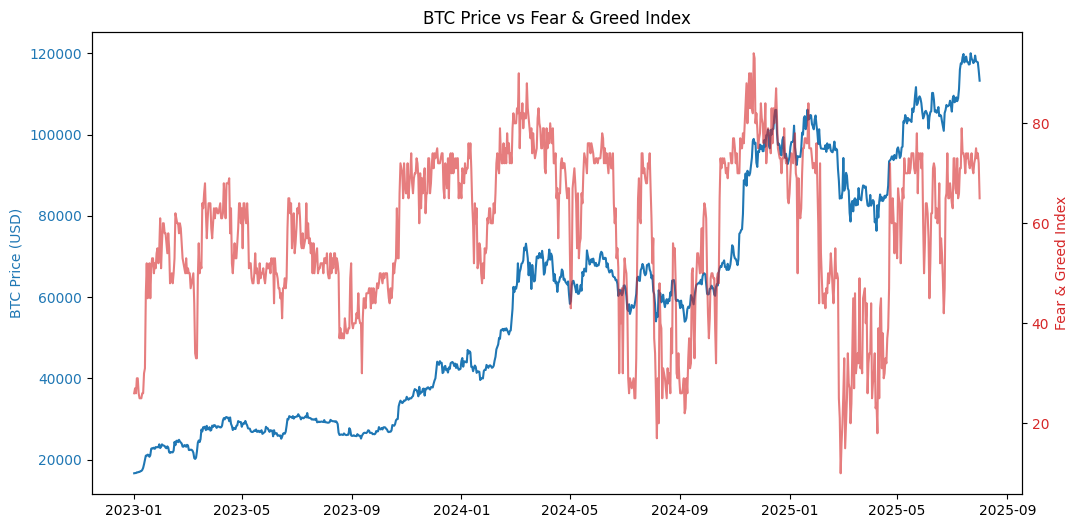

In [ ]:
# Cell 9️⃣: Visualization - kiểm tra nhanh

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_final["Date"], df_final["Close"], color='tab:blue', label="Price (Close)")
ax1.set_ylabel("BTC Price (USD)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Fear & Greed (chuẩn hóa thang 0–100)
if "fetch_fear_greed" in df_final.columns:
    ax2 = ax1.twinx()
    ax2.plot(df_final["Date"], df_final["fetch_fear_greed"], color='tab:red', alpha=0.6, label="Fear & Greed")
    ax2.set_ylabel("Fear & Greed Index", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f"{SYMBOL_BASE} Price vs Fear & Greed Index")
plt.show()


In [ ]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


📂 Đang đọc file mới nhất: dataset_BTC_20230101_20250801.csv
📏 944 dòng, 17 cột ban đầu
✅ Đã xử lý & lưu dữ liệu sạch:
- data\BTC\dataset_BTC_clean.csv
- data\BTC\dataset_BTC_clean.xlsx
📈 Tổng số dòng sau xử lý: 944



,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2023-01-01,16537.5,16618.8,16488.0,16610.3,105502.965,BTC,1.746450e+09,594299,0.000069,...,NaN,2.724834e+08,187516.000000,1.617335e+07,28.000000,1d,NaN,NaN,0.000000,26.800000
1,2023-01-02,16610.4,16799.0,16541.2,16666.0,215161.176,BTC,3.591354e+09,1020015,-0.000011,...,NaN,5.889606e+08,454811.269841,3.753554e+07,28.428571,1d,0.335334,0.003348,0.000539,27.571429
2,2023-01-03,16665.9,16774.0,16600.3,16667.2,203070.205,BTC,3.387369e+09,966813,0.000074,...,NaN,5.889606e+08,454811.269841,3.753554e+07,28.857143,1d,0.007200,0.000072,0.000550,27.142857
3,2023-01-04,16667.3,16984.6,16645.7,16842.1,349747.838,BTC,5.888327e+09,1618311,0.000049,...,NaN,2.423565e+08,277936.000000,1.551442e+07,29.285714,1d,1.049366,0.010439,0.002242,29.114286
4,2023-01-05,16842.2,16872.8,16740.4,16823.8,176369.347,BTC,2.966302e+09,892815,0.000057,...,NaN,5.889606e+08,454811.269841,3.753554e+07,29.714286,1d,-0.108656,-0.001087,0.002065,29.285714


In [27]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


📂 Đang đọc file mới nhất: dataset_BTC_clean.csv
📏 944 dòng, 21 cột ban đầu
✅ Đã xử lý & lưu dữ liệu sạch:
- data\BTC\dataset_BTC_clean.csv
- data\BTC\dataset_BTC_clean.xlsx
📈 Tổng số dòng sau xử lý: 944



,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2023-01-01,16537.5,16618.8,16488.0,16610.3,105502.965,BTC,1.746450e+09,594299,0.000069,...,NaN,2.724834e+08,187516.000000,1.617335e+07,28.000000,1d,NaN,NaN,0.000000,26.800000
1,2023-01-02,16610.4,16799.0,16541.2,16666.0,215161.176,BTC,3.591354e+09,1020015,-0.000011,...,NaN,5.889606e+08,454811.269841,3.753554e+07,28.428571,1d,0.335334,0.003348,0.000539,27.571429
2,2023-01-03,16665.9,16774.0,16600.3,16667.2,203070.205,BTC,3.387369e+09,966813,0.000074,...,NaN,5.889606e+08,454811.269841,3.753554e+07,28.857143,1d,0.007200,0.000072,0.000550,27.142857
3,2023-01-04,16667.3,16984.6,16645.7,16842.1,349747.838,BTC,5.888327e+09,1618311,0.000049,...,NaN,2.423565e+08,277936.000000,1.551442e+07,29.285714,1d,1.049366,0.010439,0.002242,29.114286
4,2023-01-05,16842.2,16872.8,16740.4,16823.8,176369.347,BTC,2.966302e+09,892815,0.000057,...,NaN,5.889606e+08,454811.269841,3.753554e+07,29.714286,1d,-0.108656,-0.001087,0.002065,29.285714


## Lấy file dữ liệu ETH


In [28]:
# Cell 1️⃣: Import & cấu hình cơ bản (phiên bản cố định, không cần nhập)
# -----------------------
# CONFIG CỐ ĐỊNH
# -----------------------

# Dữ liệu coin bạn muốn lấy
SYMBOL_BASE = "ETH"             # ví dụ: "BTC", "ETH", "BNB", "SOL", "XRP"
SYMBOL_BINANCE = SYMBOL_BASE + "USDT"   # tự tạo mã Binance Futures

# Thông tin thời gian
INTERVAL = "1d"                 # khung thời gian: "1d", "1h", ...
START_DATE = "2023-01-01"       # ngày bắt đầu
END_DATE = "2025-08-01"         # ngày kết thúc

# Thư mục lưu dữ liệu
OUT_DIR = os.path.join("data", SYMBOL_BASE)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"✅ Đang lấy dữ liệu cho {SYMBOL_BASE} ({SYMBOL_BINANCE}) từ {START_DATE} → {END_DATE}, interval={INTERVAL}")

✅ Đang lấy dữ liệu cho ETH (ETHUSDT) từ 2023-01-01 → 2025-08-01, interval=1d


In [29]:
# Cell 2️⃣: Hàm xử lý thời gian (convert timestamp <-> datetime)

def dt_to_millis(dt: datetime):
    return int(dt.replace(tzinfo=timezone.utc).timestamp() * 1000)

def date_to_millis(s):
    dt = datetime.fromisoformat(s)
    return dt_to_millis(dt)

def millis_to_date(millis):
    return datetime.fromtimestamp(millis/1000, tz=timezone.utc).date()


In [30]:
def fetch_binance_klines(symbol, interval, start_ts_ms, end_ts_ms):
    """
    Lấy dữ liệu OHLC từ Binance Futures (fallback sang Spot nếu bị chặn 418)
    """
    futures_url = "https://fapi.binance.com/fapi/v1/klines"
    spot_url = "https://api.binance.com/api/v3/klines"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    limit = 1000
    all_klines = []
    start = start_ts_ms
    use_spot = False

    while True:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start,
            "endTime": end_ts_ms,
            "limit": limit
        }

        # chọn API phù hợp
        url = spot_url if use_spot else futures_url
        try:
            r = requests.get(url, params=params, headers=headers, timeout=30)
            if r.status_code == 418:
                print(f"[WARN] Binance Futures chặn IP (418) → chuyển sang Spot API.")
                use_spot = True
                continue
            r.raise_for_status()
            data = r.json()
        except requests.exceptions.HTTPError as e:
            print(f"[ERROR] {e}")
            break
        except Exception as e:
            print(f"[WARN] Network error: {e}")
            time.sleep(5)
            continue

        if not data:
            break

        all_klines.extend(data)
        if len(data) < limit:
            break
        last_open = data[-1][0]
        start = last_open + 1
        time.sleep(0.2)

    # Chuyển sang DataFrame
    if not all_klines:
        print("[WARN] Không lấy được dữ liệu Klines.")
        return pd.DataFrame(columns=["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades","symbol"])

    cols = ["open_time","open","high","low","close","volume","close_time",
            "quote_asset_volume","num_trades","taker_buy_base_vol","taker_buy_quote_vol","ignore"]

    df = pd.DataFrame(all_klines, columns=cols)
    df["Date"] = pd.to_datetime(df["open_time"], unit="ms", utc=True).dt.date
    df = df[["Date","open","high","low","close","volume","quote_asset_volume","num_trades"]]
    df.columns = ["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]
    for c in ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["symbol"] = SYMBOL_BASE
    df = df.sort_values("Date").drop_duplicates("Date").reset_index(drop=True)

    print(f"✅ Dữ liệu Binance ({'Spot' if use_spot else 'Futures'}) tải thành công: {len(df)} dòng")
    return df


In [31]:
# Cell 4️⃣: Funding Rate trung bình theo ngày (Binance Futures)

def fetch_binance_funding(symbol, start_ts_ms, end_ts_ms):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    limit = 1000
    all_rows = []
    start = start_ts_ms

    while True:
        params = {"symbol": symbol, "startTime": start, "endTime": end_ts_ms, "limit": limit}
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        if not data:
            break

        all_rows.extend(data)
        if len(data) < limit:
            break

        last_t = data[-1]["fundingTime"]
        start = last_t + 1
        time.sleep(0.2)

    if not all_rows:
        return pd.DataFrame(columns=["Date","funding_Rate"])

    df = pd.DataFrame(all_rows)
    df["fundingTime"] = pd.to_datetime(df["fundingTime"], unit="ms", utc=True)
    df["Date"] = df["fundingTime"].dt.date
    df["fundingRate"] = pd.to_numeric(df["fundingRate"], errors="coerce")
    daily = df.groupby("Date", as_index=False)["fundingRate"].mean().rename(columns={"fundingRate":"funding_Rate"})
    return daily

In [32]:
# Cell 5️⃣: Lấy Fear & Greed Index (Alternative.me API) — phiên bản ổn định nhất

def fetch_fear_greed(limit=0):
    """
    Lấy dữ liệu Fear & Greed Index từ API alternative.me
    Trả về DataFrame có cột: Date, fetch_fear_greed
    """
    url = "https://api.alternative.me/fng/"
    params = {"limit": limit, "format": "json"}  # không dùng date_format vì không cần thiết

    try:
        r = requests.get(url, params=params, timeout=15)
        r.raise_for_status()
        j = r.json()
        data = j.get("data", [])
    except Exception as e:
        print(f"[WARN] Fear & Greed API failed: {e}")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    # Nếu rỗng, in cảnh báo
    if not data:
        print("[WARN] Fear & Greed API returned empty dataset, skipping...")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    rows = []
    for entry in data:
        try:
            ts = int(entry["timestamp"])
            value = float(entry["value"])
            date = datetime.fromtimestamp(ts, tz=timezone.utc).date()
            rows.append({"Date": date, "fetch_fear_greed": value})
        except Exception as e:
            print(f"[WARN] parse error: {e}")
            continue

    df = pd.DataFrame(rows)
    df = df.drop_duplicates("Date").sort_values("Date").reset_index(drop=True)
    print(f"✅ Fear & Greed fetched: {len(df)} rows")
    print(df.head())
    return df

In [33]:
# Cell 6️⃣: On-chain metrics (active_addresses, hash_rate, tx_count, miners_revenue)

BLOCKCHAIN_CHARTS = {
    # "active_addresses": "n-active-addresses",  # ⚠️ gỡ bỏ vì bị 404
    "hash_rate": "hash-rate",
    "tx_count": "n-transactions",
    "miners_revenue": "miners-revenue"
}


def fetch_blockchain_chart(chart_name, timespan_days=4000):
    url = f"https://api.blockchain.info/charts/{chart_name}"
    params = {"timespan": f"{timespan_days}days", "format":"json", "sampled":False}
    r = requests.get(url, params=params, timeout=30)
    if r.status_code != 200:
        r = requests.get(url, params={"timespan":f"{timespan_days}days","format":"json"}, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f"Blockchain.info chart {chart_name} returned {r.status_code}")

    j = r.json()
    values = j.get("values", [])
    rows = [{"Date": datetime.fromtimestamp(v["x"], tz=timezone.utc).date(), chart_name: v["y"]} for v in values]
    return pd.DataFrame(rows).drop_duplicates("Date").sort_values("Date").reset_index(drop=True)

def fetch_onchain_from_blockchain_info(mapping):
    dfs = []
    for outcol, chart in mapping.items():
        try:
            dfc = fetch_blockchain_chart(chart, timespan_days=5000)
            dfc = dfc.rename(columns={chart: outcol})
            dfs.append(dfc)
            time.sleep(0.2)
        except Exception as e:
            print(f"[WARN] Could not fetch chart {chart}: {e}")
    if not dfs:
        return pd.DataFrame(columns=["Date"])
    df_merged = dfs[0]
    for d in dfs[1:]:
        df_merged = pd.merge(df_merged, d, on="Date", how="outer")
    return df_merged.sort_values("Date").reset_index(drop=True)

In [34]:
# Cell 6️⃣b: Lấy dữ liệu Google Trends (Interest Over Time) - có delay và fallback

def fetch_google_trend(symbol_base: str, start_date: str, end_date: str):
    """
    Lấy độ quan tâm Google Trends (Interest Over Time)
    Có delay tránh 429, và fallback từ file local nếu API bị chặn.
    """
    kw = symbol_base.lower()
    if kw == "btc": kw = "bitcoin"
    elif kw == "eth": kw = "ethereum"

    local_path = os.path.join("data", symbol_base, f"google_trend_{symbol_base}.csv")

    # Nếu có file cũ thì đọc lại
    if os.path.exists(local_path):
        print(f"📂 Đọc cache Google Trends từ {local_path}")
        df_cached = pd.read_csv(local_path)
        df_cached["Date"] = pd.to_datetime(df_cached["Date"]).dt.date
        return df_cached

    # Nếu chưa có cache -> gọi API
    time.sleep(random.uniform(10, 20))
    pytrends = TrendReq(hl='en-US', tz=0)
    timeframe = f"{start_date} {end_date}"
    try:
        pytrends.build_payload([kw], timeframe=timeframe)
        df_trend = pytrends.interest_over_time()
    except Exception as e:
        print(f"[WARN] Pytrends failed: {e}")
        return pd.DataFrame(columns=["Date", "google_interest"])

    if df_trend.empty:
        print("[WARN] Pytrends returned empty data.")
        return pd.DataFrame(columns=["Date", "google_interest"])

    df_trend = df_trend.reset_index()
    df_trend["Date"] = df_trend["date"].dt.date
    df_trend = df_trend.rename(columns={kw: "google_interest"})
    df_trend = df_trend[["Date", "google_interest"]]

    # Lưu cache
    df_trend.to_csv(local_path, index=False)
    print(f"✅ Lưu cache: {local_path}")
    return df_trend

In [35]:
# Cell 7️⃣ (cập nhật thêm pytrends)

def build_dataset():
    start_ts = date_to_millis(START_DATE)
    end_dt = datetime.fromisoformat(END_DATE)
    end_of_day = datetime(end_dt.year, end_dt.month, end_dt.day, 23, 59, 59, tzinfo=timezone.utc)
    end_ts = int(end_of_day.timestamp() * 1000)

    print("Fetching klines from Binance futures...")
    df_klines = fetch_binance_klines(SYMBOL_BINANCE, INTERVAL, start_ts, end_ts)
    print(f"klines rows: {len(df_klines)}")

    print("Fetching funding rates...")
    df_fund = fetch_binance_funding(SYMBOL_BINANCE, start_ts, end_ts)
    print(f"funding rows: {len(df_fund)}")

    print("Fetching Fear & Greed index...")
    df_fng = fetch_fear_greed(limit=0)
    print(f"fear&greed rows: {len(df_fng)}")

    print("Fetching on-chain metrics...")
    df_onchain = fetch_onchain_from_blockchain_info(BLOCKCHAIN_CHARTS)
    print(f"onchain rows: {len(df_onchain)}")

    # 🔍 Thêm phần Google Trends
    print("Fetching Google Trends interest...")
    df_trend = fetch_google_trend(SYMBOL_BASE, START_DATE, END_DATE)

    # Merge các bảng
    df = df_klines.copy()
    df = pd.merge(df, df_fund, on="Date", how="left")
    df = pd.merge(df, df_fng, on="Date", how="left")
    df = pd.merge(df, df_onchain, on="Date", how="left")
    df = pd.merge(df, df_trend, on="Date", how="left")  # 🔍 thêm dòng này

    # Bổ sung cột thiếu
    for col in ["funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]:
        if col not in df.columns:
            df[col] = pd.NA

    df["time_frame"] = INTERVAL

    # Thứ tự cột cuối cùng
    final_cols = ["Date","Open","High","Low","Close","Volume","symbol",
                  "Quote_Volume","Number_Of_Trades","funding_Rate","fetch_fear_greed",
                  "active_addresses","hash_rate","tx_count","miners_revenue",
                  "google_interest","time_frame"]

    df = df[[c for c in final_cols if c in df.columns]]

    # Xuất file
    start_tag = datetime.fromisoformat(START_DATE).strftime("%Y%m%d")
    end_tag = end_dt.strftime("%Y%m%d")
    out_csv = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.csv")
    out_xlsx = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.xlsx")

    df.to_csv(out_csv, index=False)
    df.to_excel(out_xlsx, index=False)
    print(f"✅ Saved CSV: {out_csv}")
    print(f"✅ Saved XLSX: {out_xlsx}")

    return df

In [36]:
# Cell 8️⃣: Chạy chính
df_final = build_dataset()
print("\n✅ Hoàn tất! Xem 10 dòng đầu:")
df_final.head(10)

Fetching klines from Binance futures...
✅ Dữ liệu Binance (Futures) tải thành công: 944 dòng
klines rows: 944
Fetching funding rates...
funding rows: 944
Fetching Fear & Greed index...
✅ Fear & Greed fetched: 2823 rows
         Date  fetch_fear_greed
0  2018-02-01              30.0
1  2018-02-02              15.0
2  2018-02-03              40.0
3  2018-02-04              24.0
4  2018-02-05              11.0
fear&greed rows: 2823
Fetching on-chain metrics...
onchain rows: 1667
Fetching Google Trends interest...
✅ Lưu cache: data\ETH\google_trend_ETH.csv
✅ Saved CSV: data\ETH\dataset_ETH_20230101_20250801.csv
✅ Saved XLSX: data\ETH\dataset_ETH_20230101_20250801.xlsx

✅ Hoàn tất! Xem 10 dòng đầu:


,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,fetch_fear_greed,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame
0,2023-01-01,1196.10,1204.79,1190.80,1199.96,1381763.488,ETH,1.654444e+09,683700,0.000100,26.0,<NA>,2.724834e+08,187516.0,1.617335e+07,37.0,1d
1,2023-01-02,1199.96,1225.00,1191.50,1213.23,2831791.319,ETH,3.431524e+09,1194079,0.000088,27.0,<NA>,NaN,NaN,NaN,NaN,1d
2,2023-01-03,1213.24,1219.50,1203.05,1214.23,2418195.012,ETH,2.931903e+09,1012410,0.000030,26.0,<NA>,NaN,NaN,NaN,NaN,1d
3,2023-01-04,1214.22,1275.00,1212.16,1256.39,5329817.195,ETH,6.655448e+09,2182199,0.000092,29.0,<NA>,2.423565e+08,277936.0,1.551442e+07,NaN,1d
4,2023-01-05,1256.39,1260.00,1242.22,1251.08,2662864.999,ETH,3.329922e+09,1160417,0.000100,29.0,<NA>,NaN,NaN,NaN,NaN,1d
5,2023-01-06,1251.08,1277.77,1233.00,1268.54,4156167.363,ETH,5.216520e+09,1805807,0.000100,26.0,<NA>,NaN,NaN,NaN,NaN,1d
6,2023-01-07,1268.54,1270.66,1260.53,1263.65,1186947.058,ETH,1.500580e+09,625140,0.000056,25.0,<NA>,2.609993e+08,246679.0,1.666961e+07,NaN,1d
7,2023-01-08,1263.64,1296.00,1256.30,1289.65,2415068.332,ETH,3.068138e+09,1138729,0.000065,25.0,<NA>,NaN,NaN,NaN,49.0,1d
8,2023-01-09,1289.64,1345.00,1284.81,1320.32,6326600.832,ETH,8.343050e+09,2548577,0.000073,25.0,<NA>,NaN,NaN,NaN,NaN,1d
9,2023-01-10,1320.32,1348.70,1316.74,1335.30,3653151.641,ETH,4.864321e+09,1599802,0.000100,26.0,<NA>,2.864213e+08,302809.0,1.867144e+07,NaN,1d


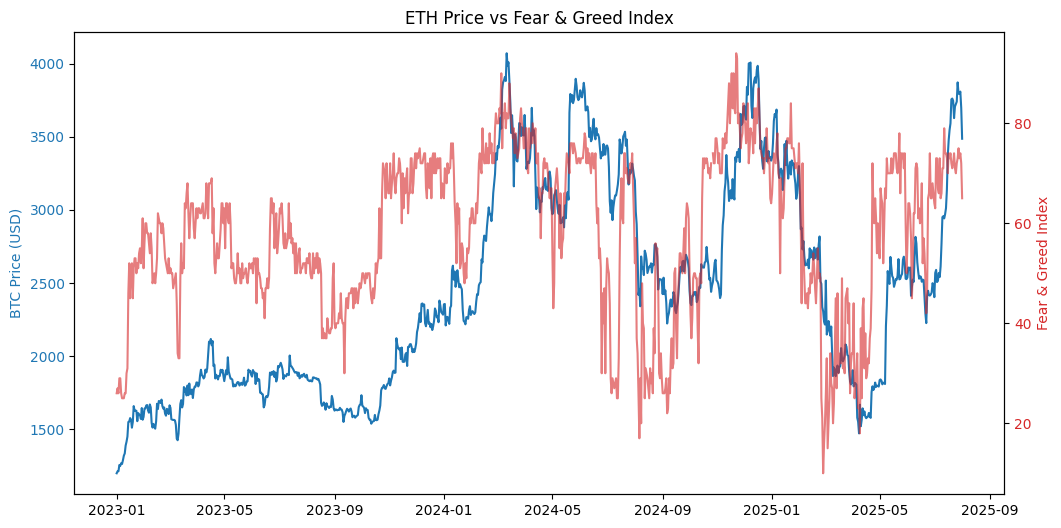

In [37]:
# Cell 9️⃣: Visualization - kiểm tra nhanh

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_final["Date"], df_final["Close"], color='tab:blue', label="Price (Close)")
ax1.set_ylabel("BTC Price (USD)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Fear & Greed (chuẩn hóa thang 0–100)
if "fetch_fear_greed" in df_final.columns:
    ax2 = ax1.twinx()
    ax2.plot(df_final["Date"], df_final["fetch_fear_greed"], color='tab:red', alpha=0.6, label="Fear & Greed")
    ax2.set_ylabel("Fear & Greed Index", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f"{SYMBOL_BASE} Price vs Fear & Greed Index")
plt.show()


In [38]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


📂 Đang đọc file mới nhất: dataset_ETH_20230101_20250801.csv
📏 944 dòng, 17 cột ban đầu
✅ Đã xử lý & lưu dữ liệu sạch:
- data\ETH\dataset_ETH_clean.csv
- data\ETH\dataset_ETH_clean.xlsx
📈 Tổng số dòng sau xử lý: 944



,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2023-01-01,1196.10,1204.79,1190.80,1199.96,1381763.488,ETH,1.654444e+09,683700,0.000100,...,NaN,2.724834e+08,187516.000000,1.617335e+07,37.000000,1d,NaN,NaN,0.000000,30.400000
1,2023-01-02,1199.96,1225.00,1191.50,1213.23,2831791.319,ETH,3.431524e+09,1194079,0.000088,...,NaN,5.889606e+08,454811.269841,3.753554e+07,38.714286,1d,1.105870,0.010998,0.004623,31.685714
2,2023-01-03,1213.24,1219.50,1203.05,1214.23,2418195.012,ETH,2.931903e+09,1012410,0.000030,...,NaN,5.889606e+08,454811.269841,3.753554e+07,40.428571,1d,0.082425,0.000824,0.004971,31.771429
3,2023-01-04,1214.22,1275.00,1212.16,1256.39,5329817.195,ETH,6.655448e+09,2182199,0.000092,...,NaN,2.423565e+08,277936.000000,1.551442e+07,42.142857,1d,3.472159,0.034132,0.019658,34.257143
4,2023-01-05,1256.39,1260.00,1242.22,1251.08,2662864.999,ETH,3.329922e+09,1160417,0.000100,...,NaN,5.889606e+08,454811.269841,3.753554e+07,43.857143,1d,-0.422639,-0.004235,0.017808,34.942857


In [39]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


📂 Đang đọc file mới nhất: dataset_ETH_clean.csv
📏 944 dòng, 21 cột ban đầu
✅ Đã xử lý & lưu dữ liệu sạch:
- data\ETH\dataset_ETH_clean.csv
- data\ETH\dataset_ETH_clean.xlsx
📈 Tổng số dòng sau xử lý: 944



,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2023-01-01,1196.10,1204.79,1190.80,1199.96,1381763.488,ETH,1.654444e+09,683700,0.000100,...,NaN,2.724834e+08,187516.000000,1.617335e+07,37.000000,1d,NaN,NaN,0.000000,30.400000
1,2023-01-02,1199.96,1225.00,1191.50,1213.23,2831791.319,ETH,3.431524e+09,1194079,0.000088,...,NaN,5.889606e+08,454811.269841,3.753554e+07,38.714286,1d,1.105870,0.010998,0.004623,31.685714
2,2023-01-03,1213.24,1219.50,1203.05,1214.23,2418195.012,ETH,2.931903e+09,1012410,0.000030,...,NaN,5.889606e+08,454811.269841,3.753554e+07,40.428571,1d,0.082425,0.000824,0.004971,31.771429
3,2023-01-04,1214.22,1275.00,1212.16,1256.39,5329817.195,ETH,6.655448e+09,2182199,0.000092,...,NaN,2.423565e+08,277936.000000,1.551442e+07,42.142857,1d,3.472159,0.034132,0.019658,34.257143
4,2023-01-05,1256.39,1260.00,1242.22,1251.08,2662864.999,ETH,3.329922e+09,1160417,0.000100,...,NaN,5.889606e+08,454811.269841,3.753554e+07,43.857143,1d,-0.422639,-0.004235,0.017808,34.942857


## Lấy file dữ liệu BNB


In [40]:
# Cell 1️⃣: Import & cấu hình cơ bản (phiên bản cố định, không cần nhập)
# -----------------------
# CONFIG CỐ ĐỊNH
# -----------------------

# Dữ liệu coin bạn muốn lấy
SYMBOL_BASE = "BNB"             # ví dụ: "BTC", "ETH", "BNB", "SOL", "XRP"
SYMBOL_BINANCE = SYMBOL_BASE + "USDT"   # tự tạo mã Binance Futures

# Thông tin thời gian
INTERVAL = "1d"                 # khung thời gian: "1d", "1h", ...
START_DATE = "2023-01-01"       # ngày bắt đầu
END_DATE = "2025-08-01"         # ngày kết thúc

# Thư mục lưu dữ liệu
OUT_DIR = os.path.join("data", SYMBOL_BASE)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"✅ Đang lấy dữ liệu cho {SYMBOL_BASE} ({SYMBOL_BINANCE}) từ {START_DATE} → {END_DATE}, interval={INTERVAL}")

✅ Đang lấy dữ liệu cho BNB (BNBUSDT) từ 2023-01-01 → 2025-08-01, interval=1d


In [41]:
# Cell 2️⃣: Hàm xử lý thời gian (convert timestamp <-> datetime)

def dt_to_millis(dt: datetime):
    return int(dt.replace(tzinfo=timezone.utc).timestamp() * 1000)

def date_to_millis(s):
    dt = datetime.fromisoformat(s)
    return dt_to_millis(dt)

def millis_to_date(millis):
    return datetime.fromtimestamp(millis/1000, tz=timezone.utc).date()


In [42]:
def fetch_binance_klines(symbol, interval, start_ts_ms, end_ts_ms):
    """
    Lấy dữ liệu OHLC từ Binance Futures (fallback sang Spot nếu bị chặn 418)
    """
    futures_url = "https://fapi.binance.com/fapi/v1/klines"
    spot_url = "https://api.binance.com/api/v3/klines"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    limit = 1000
    all_klines = []
    start = start_ts_ms
    use_spot = False

    while True:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start,
            "endTime": end_ts_ms,
            "limit": limit
        }

        # chọn API phù hợp
        url = spot_url if use_spot else futures_url
        try:
            r = requests.get(url, params=params, headers=headers, timeout=30)
            if r.status_code == 418:
                print(f"[WARN] Binance Futures chặn IP (418) → chuyển sang Spot API.")
                use_spot = True
                continue
            r.raise_for_status()
            data = r.json()
        except requests.exceptions.HTTPError as e:
            print(f"[ERROR] {e}")
            break
        except Exception as e:
            print(f"[WARN] Network error: {e}")
            time.sleep(5)
            continue

        if not data:
            break

        all_klines.extend(data)
        if len(data) < limit:
            break
        last_open = data[-1][0]
        start = last_open + 1
        time.sleep(0.2)

    # Chuyển sang DataFrame
    if not all_klines:
        print("[WARN] Không lấy được dữ liệu Klines.")
        return pd.DataFrame(columns=["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades","symbol"])

    cols = ["open_time","open","high","low","close","volume","close_time",
            "quote_asset_volume","num_trades","taker_buy_base_vol","taker_buy_quote_vol","ignore"]

    df = pd.DataFrame(all_klines, columns=cols)
    df["Date"] = pd.to_datetime(df["open_time"], unit="ms", utc=True).dt.date
    df = df[["Date","open","high","low","close","volume","quote_asset_volume","num_trades"]]
    df.columns = ["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]
    for c in ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["symbol"] = SYMBOL_BASE
    df = df.sort_values("Date").drop_duplicates("Date").reset_index(drop=True)

    print(f"✅ Dữ liệu Binance ({'Spot' if use_spot else 'Futures'}) tải thành công: {len(df)} dòng")
    return df


In [43]:
# Cell 4️⃣: Funding Rate trung bình theo ngày (Binance Futures)

def fetch_binance_funding(symbol, start_ts_ms, end_ts_ms):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    limit = 1000
    all_rows = []
    start = start_ts_ms

    while True:
        params = {"symbol": symbol, "startTime": start, "endTime": end_ts_ms, "limit": limit}
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        if not data:
            break

        all_rows.extend(data)
        if len(data) < limit:
            break

        last_t = data[-1]["fundingTime"]
        start = last_t + 1
        time.sleep(0.2)

    if not all_rows:
        return pd.DataFrame(columns=["Date","funding_Rate"])

    df = pd.DataFrame(all_rows)
    df["fundingTime"] = pd.to_datetime(df["fundingTime"], unit="ms", utc=True)
    df["Date"] = df["fundingTime"].dt.date
    df["fundingRate"] = pd.to_numeric(df["fundingRate"], errors="coerce")
    daily = df.groupby("Date", as_index=False)["fundingRate"].mean().rename(columns={"fundingRate":"funding_Rate"})
    return daily

In [44]:
# Cell 5️⃣: Lấy Fear & Greed Index (Alternative.me API) — phiên bản ổn định nhất

def fetch_fear_greed(limit=0):
    """
    Lấy dữ liệu Fear & Greed Index từ API alternative.me
    Trả về DataFrame có cột: Date, fetch_fear_greed
    """
    url = "https://api.alternative.me/fng/"
    params = {"limit": limit, "format": "json"}  # không dùng date_format vì không cần thiết

    try:
        r = requests.get(url, params=params, timeout=15)
        r.raise_for_status()
        j = r.json()
        data = j.get("data", [])
    except Exception as e:
        print(f"[WARN] Fear & Greed API failed: {e}")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    # Nếu rỗng, in cảnh báo
    if not data:
        print("[WARN] Fear & Greed API returned empty dataset, skipping...")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    rows = []
    for entry in data:
        try:
            ts = int(entry["timestamp"])
            value = float(entry["value"])
            date = datetime.fromtimestamp(ts, tz=timezone.utc).date()
            rows.append({"Date": date, "fetch_fear_greed": value})
        except Exception as e:
            print(f"[WARN] parse error: {e}")
            continue

    df = pd.DataFrame(rows)
    df = df.drop_duplicates("Date").sort_values("Date").reset_index(drop=True)
    print(f"✅ Fear & Greed fetched: {len(df)} rows")
    print(df.head())
    return df

In [45]:
# Cell 6️⃣: On-chain metrics (active_addresses, hash_rate, tx_count, miners_revenue)

BLOCKCHAIN_CHARTS = {
    # "active_addresses": "n-active-addresses",  # ⚠️ gỡ bỏ vì bị 404
    "hash_rate": "hash-rate",
    "tx_count": "n-transactions",
    "miners_revenue": "miners-revenue"
}


def fetch_blockchain_chart(chart_name, timespan_days=4000):
    url = f"https://api.blockchain.info/charts/{chart_name}"
    params = {"timespan": f"{timespan_days}days", "format":"json", "sampled":False}
    r = requests.get(url, params=params, timeout=30)
    if r.status_code != 200:
        r = requests.get(url, params={"timespan":f"{timespan_days}days","format":"json"}, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f"Blockchain.info chart {chart_name} returned {r.status_code}")

    j = r.json()
    values = j.get("values", [])
    rows = [{"Date": datetime.fromtimestamp(v["x"], tz=timezone.utc).date(), chart_name: v["y"]} for v in values]
    return pd.DataFrame(rows).drop_duplicates("Date").sort_values("Date").reset_index(drop=True)

def fetch_onchain_from_blockchain_info(mapping):
    dfs = []
    for outcol, chart in mapping.items():
        try:
            dfc = fetch_blockchain_chart(chart, timespan_days=5000)
            dfc = dfc.rename(columns={chart: outcol})
            dfs.append(dfc)
            time.sleep(0.2)
        except Exception as e:
            print(f"[WARN] Could not fetch chart {chart}: {e}")
    if not dfs:
        return pd.DataFrame(columns=["Date"])
    df_merged = dfs[0]
    for d in dfs[1:]:
        df_merged = pd.merge(df_merged, d, on="Date", how="outer")
    return df_merged.sort_values("Date").reset_index(drop=True)

In [46]:
# Cell 6️⃣b: Lấy dữ liệu Google Trends (Interest Over Time) - có delay và fallback

def fetch_google_trend(symbol_base: str, start_date: str, end_date: str):
    """
    Lấy độ quan tâm Google Trends (Interest Over Time)
    Có delay tránh 429, và fallback từ file local nếu API bị chặn.
    """
    kw = symbol_base.lower()
    if kw == "btc": kw = "bitcoin"
    elif kw == "eth": kw = "ethereum"

    local_path = os.path.join("data", symbol_base, f"google_trend_{symbol_base}.csv")

    # Nếu có file cũ thì đọc lại
    if os.path.exists(local_path):
        print(f"📂 Đọc cache Google Trends từ {local_path}")
        df_cached = pd.read_csv(local_path)
        df_cached["Date"] = pd.to_datetime(df_cached["Date"]).dt.date
        return df_cached

    # Nếu chưa có cache -> gọi API
    time.sleep(random.uniform(10, 20))
    pytrends = TrendReq(hl='en-US', tz=0)
    timeframe = f"{start_date} {end_date}"
    try:
        pytrends.build_payload([kw], timeframe=timeframe)
        df_trend = pytrends.interest_over_time()
    except Exception as e:
        print(f"[WARN] Pytrends failed: {e}")
        return pd.DataFrame(columns=["Date", "google_interest"])

    if df_trend.empty:
        print("[WARN] Pytrends returned empty data.")
        return pd.DataFrame(columns=["Date", "google_interest"])

    df_trend = df_trend.reset_index()
    df_trend["Date"] = df_trend["date"].dt.date
    df_trend = df_trend.rename(columns={kw: "google_interest"})
    df_trend = df_trend[["Date", "google_interest"]]

    # Lưu cache
    df_trend.to_csv(local_path, index=False)
    print(f"✅ Lưu cache: {local_path}")
    return df_trend

In [47]:
# Cell 7️⃣ (cập nhật thêm pytrends)

def build_dataset():
    start_ts = date_to_millis(START_DATE)
    end_dt = datetime.fromisoformat(END_DATE)
    end_of_day = datetime(end_dt.year, end_dt.month, end_dt.day, 23, 59, 59, tzinfo=timezone.utc)
    end_ts = int(end_of_day.timestamp() * 1000)

    print("Fetching klines from Binance futures...")
    df_klines = fetch_binance_klines(SYMBOL_BINANCE, INTERVAL, start_ts, end_ts)
    print(f"klines rows: {len(df_klines)}")

    print("Fetching funding rates...")
    df_fund = fetch_binance_funding(SYMBOL_BINANCE, start_ts, end_ts)
    print(f"funding rows: {len(df_fund)}")

    print("Fetching Fear & Greed index...")
    df_fng = fetch_fear_greed(limit=0)
    print(f"fear&greed rows: {len(df_fng)}")

    print("Fetching on-chain metrics...")
    df_onchain = fetch_onchain_from_blockchain_info(BLOCKCHAIN_CHARTS)
    print(f"onchain rows: {len(df_onchain)}")

    # 🔍 Thêm phần Google Trends
    print("Fetching Google Trends interest...")
    df_trend = fetch_google_trend(SYMBOL_BASE, START_DATE, END_DATE)

    # Merge các bảng
    df = df_klines.copy()
    df = pd.merge(df, df_fund, on="Date", how="left")
    df = pd.merge(df, df_fng, on="Date", how="left")
    df = pd.merge(df, df_onchain, on="Date", how="left")
    df = pd.merge(df, df_trend, on="Date", how="left")  # 🔍 thêm dòng này

    # Bổ sung cột thiếu
    for col in ["funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]:
        if col not in df.columns:
            df[col] = pd.NA

    df["time_frame"] = INTERVAL

    # Thứ tự cột cuối cùng
    final_cols = ["Date","Open","High","Low","Close","Volume","symbol",
                  "Quote_Volume","Number_Of_Trades","funding_Rate","fetch_fear_greed",
                  "active_addresses","hash_rate","tx_count","miners_revenue",
                  "google_interest","time_frame"]

    df = df[[c for c in final_cols if c in df.columns]]

    # Xuất file
    start_tag = datetime.fromisoformat(START_DATE).strftime("%Y%m%d")
    end_tag = end_dt.strftime("%Y%m%d")
    out_csv = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.csv")
    out_xlsx = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.xlsx")

    df.to_csv(out_csv, index=False)
    df.to_excel(out_xlsx, index=False)
    print(f"✅ Saved CSV: {out_csv}")
    print(f"✅ Saved XLSX: {out_xlsx}")

    return df

In [48]:
# Cell 8️⃣: Chạy chính
df_final = build_dataset()
print("\n✅ Hoàn tất! Xem 10 dòng đầu:")
df_final.head(10)

Fetching klines from Binance futures...
✅ Dữ liệu Binance (Futures) tải thành công: 944 dòng
klines rows: 944
Fetching funding rates...
funding rows: 944
Fetching Fear & Greed index...
✅ Fear & Greed fetched: 2823 rows
         Date  fetch_fear_greed
0  2018-02-01              30.0
1  2018-02-02              15.0
2  2018-02-03              40.0
3  2018-02-04              24.0
4  2018-02-05              11.0
fear&greed rows: 2823
Fetching on-chain metrics...
onchain rows: 1667
Fetching Google Trends interest...
✅ Lưu cache: data\BNB\google_trend_BNB.csv
✅ Saved CSV: data\BNB\dataset_BNB_20230101_20250801.csv
✅ Saved XLSX: data\BNB\dataset_BNB_20230101_20250801.xlsx

✅ Hoàn tất! Xem 10 dòng đầu:


,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,fetch_fear_greed,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame
0,2023-01-01,246.11,246.59,243.25,244.36,793153.38,BNB,1.939856e+08,246426,-0.000003,26.0,<NA>,2.724834e+08,187516.0,1.617335e+07,76.0,1d
1,2023-01-02,244.35,247.88,240.40,245.07,1476135.06,BNB,3.620143e+08,407787,-0.000025,27.0,<NA>,NaN,NaN,NaN,NaN,1d
2,2023-01-03,245.06,246.90,244.02,245.97,917619.33,BNB,2.252540e+08,287346,-0.000052,26.0,<NA>,NaN,NaN,NaN,NaN,1d
3,2023-01-04,245.97,260.90,245.47,258.54,2601842.57,BNB,6.647247e+08,747686,0.000000,29.0,<NA>,2.423565e+08,277936.0,1.551442e+07,NaN,1d
4,2023-01-05,258.55,258.90,255.00,256.44,1016972.84,BNB,2.612803e+08,344953,-0.000396,29.0,<NA>,NaN,NaN,NaN,NaN,1d
5,2023-01-06,256.43,260.50,253.95,259.69,1642251.62,BNB,4.226478e+08,519824,-0.000238,26.0,<NA>,NaN,NaN,NaN,NaN,1d
6,2023-01-07,259.69,264.00,259.21,261.11,722545.09,BNB,1.886452e+08,295305,-0.000221,25.0,<NA>,2.609993e+08,246679.0,1.666961e+07,NaN,1d
7,2023-01-08,261.10,277.00,259.83,274.70,1576056.16,BNB,4.194799e+08,512241,-0.000178,25.0,<NA>,NaN,NaN,NaN,78.0,1d
8,2023-01-09,274.70,283.55,271.27,272.44,2398756.73,BNB,6.662423e+08,791760,-0.000018,25.0,<NA>,NaN,NaN,NaN,NaN,1d
9,2023-01-10,272.44,278.65,270.07,277.02,1433539.80,BNB,3.942497e+08,493344,-0.000006,26.0,<NA>,2.864213e+08,302809.0,1.867144e+07,NaN,1d


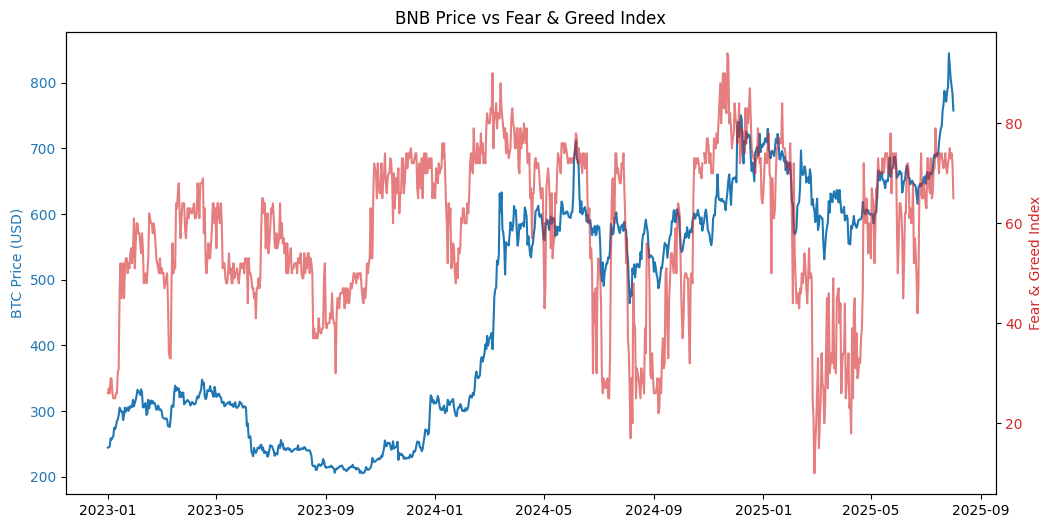

In [49]:
# Cell 9️⃣: Visualization - kiểm tra nhanh

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_final["Date"], df_final["Close"], color='tab:blue', label="Price (Close)")
ax1.set_ylabel("BTC Price (USD)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Fear & Greed (chuẩn hóa thang 0–100)
if "fetch_fear_greed" in df_final.columns:
    ax2 = ax1.twinx()
    ax2.plot(df_final["Date"], df_final["fetch_fear_greed"], color='tab:red', alpha=0.6, label="Fear & Greed")
    ax2.set_ylabel("Fear & Greed Index", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f"{SYMBOL_BASE} Price vs Fear & Greed Index")
plt.show()


In [50]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


📂 Đang đọc file mới nhất: dataset_BNB_20230101_20250801.csv
📏 944 dòng, 17 cột ban đầu
✅ Đã xử lý & lưu dữ liệu sạch:
- data\BNB\dataset_BNB_clean.csv
- data\BNB\dataset_BNB_clean.xlsx
📈 Tổng số dòng sau xử lý: 944



,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2023-01-01,246.11,246.59,243.25,244.36,793153.38,BNB,1.939856e+08,246426,-0.000003,...,NaN,2.724834e+08,187516.000000,1.617335e+07,76.000000,1d,NaN,NaN,0.061094,46.000000
1,2023-01-02,244.35,247.88,240.40,245.07,1476135.06,BNB,3.620143e+08,407787,-0.000025,...,NaN,5.889606e+08,454811.269841,3.753554e+07,76.285714,1d,0.290555,0.002901,0.062204,46.714286
2,2023-01-03,245.06,246.90,244.02,245.97,917619.33,BNB,2.252540e+08,287346,-0.000052,...,NaN,5.889606e+08,454811.269841,3.753554e+07,76.571429,1d,0.367242,0.003666,0.063611,46.228571
3,2023-01-04,245.97,260.90,245.47,258.54,2601842.57,BNB,6.647247e+08,747686,0.000000,...,NaN,2.423565e+08,277936.000000,1.551442e+07,76.857143,1d,5.110379,0.049841,0.083267,48.142857
4,2023-01-05,258.55,258.90,255.00,256.44,1016972.84,BNB,2.612803e+08,344953,-0.000396,...,NaN,5.889606e+08,454811.269841,3.753554e+07,77.142857,1d,-0.812253,-0.008156,0.079983,48.257143


In [51]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


📂 Đang đọc file mới nhất: dataset_BNB_clean.csv
📏 944 dòng, 21 cột ban đầu
✅ Đã xử lý & lưu dữ liệu sạch:
- data\BNB\dataset_BNB_clean.csv
- data\BNB\dataset_BNB_clean.xlsx
📈 Tổng số dòng sau xử lý: 944



,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2023-01-01,246.11,246.59,243.25,244.36,793153.38,BNB,1.939856e+08,246426,-0.000003,...,NaN,2.724834e+08,187516.000000,1.617335e+07,76.000000,1d,NaN,NaN,0.061094,46.000000
1,2023-01-02,244.35,247.88,240.40,245.07,1476135.06,BNB,3.620143e+08,407787,-0.000025,...,NaN,5.889606e+08,454811.269841,3.753554e+07,76.285714,1d,0.290555,0.002901,0.062204,46.714286
2,2023-01-03,245.06,246.90,244.02,245.97,917619.33,BNB,2.252540e+08,287346,-0.000052,...,NaN,5.889606e+08,454811.269841,3.753554e+07,76.571429,1d,0.367242,0.003666,0.063611,46.228571
3,2023-01-04,245.97,260.90,245.47,258.54,2601842.57,BNB,6.647247e+08,747686,0.000000,...,NaN,2.423565e+08,277936.000000,1.551442e+07,76.857143,1d,5.110379,0.049841,0.083267,48.142857
4,2023-01-05,258.55,258.90,255.00,256.44,1016972.84,BNB,2.612803e+08,344953,-0.000396,...,NaN,5.889606e+08,454811.269841,3.753554e+07,77.142857,1d,-0.812253,-0.008156,0.079983,48.257143


## Lấy file dữ liệu SOL


In [ ]:
# Cell 1️⃣: Import & cấu hình cơ bản (phiên bản cố định, không cần nhập)
# -----------------------
# CONFIG CỐ ĐỊNH
# -----------------------

# Dữ liệu coin bạn muốn lấy
SYMBOL_BASE = "SOL"             # ví dụ: "BTC", "ETH", "BNB", "SOL", "XRP"
SYMBOL_BINANCE = SYMBOL_BASE + "USDT"   # tự tạo mã Binance Futures

# Thông tin thời gian
INTERVAL = "1d"                 # khung thời gian: "1d", "1h", ...
START_DATE = "2023-01-01"       # ngày bắt đầu
END_DATE = "2025-08-01"         # ngày kết thúc

# Thư mục lưu dữ liệu
OUT_DIR = os.path.join("data", SYMBOL_BASE)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"✅ Đang lấy dữ liệu cho {SYMBOL_BASE} ({SYMBOL_BINANCE}) từ {START_DATE} → {END_DATE}, interval={INTERVAL}")

✅ Đang lấy dữ liệu cho BTC (BTCUSDT) từ 2023-01-01 → 2025-08-01, interval=1d


In [ ]:
# Cell 2️⃣: Hàm xử lý thời gian (convert timestamp <-> datetime)

def dt_to_millis(dt: datetime):
    return int(dt.replace(tzinfo=timezone.utc).timestamp() * 1000)

def date_to_millis(s):
    dt = datetime.fromisoformat(s)
    return dt_to_millis(dt)

def millis_to_date(millis):
    return datetime.fromtimestamp(millis/1000, tz=timezone.utc).date()


In [ ]:
def fetch_binance_klines(symbol, interval, start_ts_ms, end_ts_ms):
    """
    Lấy dữ liệu OHLC từ Binance Futures (fallback sang Spot nếu bị chặn 418)
    """
    futures_url = "https://fapi.binance.com/fapi/v1/klines"
    spot_url = "https://api.binance.com/api/v3/klines"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    limit = 1000
    all_klines = []
    start = start_ts_ms
    use_spot = False

    while True:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start,
            "endTime": end_ts_ms,
            "limit": limit
        }

        # chọn API phù hợp
        url = spot_url if use_spot else futures_url
        try:
            r = requests.get(url, params=params, headers=headers, timeout=30)
            if r.status_code == 418:
                print(f"[WARN] Binance Futures chặn IP (418) → chuyển sang Spot API.")
                use_spot = True
                continue
            r.raise_for_status()
            data = r.json()
        except requests.exceptions.HTTPError as e:
            print(f"[ERROR] {e}")
            break
        except Exception as e:
            print(f"[WARN] Network error: {e}")
            time.sleep(5)
            continue

        if not data:
            break

        all_klines.extend(data)
        if len(data) < limit:
            break
        last_open = data[-1][0]
        start = last_open + 1
        time.sleep(0.2)

    # Chuyển sang DataFrame
    if not all_klines:
        print("[WARN] Không lấy được dữ liệu Klines.")
        return pd.DataFrame(columns=["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades","symbol"])

    cols = ["open_time","open","high","low","close","volume","close_time",
            "quote_asset_volume","num_trades","taker_buy_base_vol","taker_buy_quote_vol","ignore"]

    df = pd.DataFrame(all_klines, columns=cols)
    df["Date"] = pd.to_datetime(df["open_time"], unit="ms", utc=True).dt.date
    df = df[["Date","open","high","low","close","volume","quote_asset_volume","num_trades"]]
    df.columns = ["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]
    for c in ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["symbol"] = SYMBOL_BASE
    df = df.sort_values("Date").drop_duplicates("Date").reset_index(drop=True)

    print(f"✅ Dữ liệu Binance ({'Spot' if use_spot else 'Futures'}) tải thành công: {len(df)} dòng")
    return df


In [ ]:
# Cell 4️⃣: Funding Rate trung bình theo ngày (Binance Futures)

def fetch_binance_funding(symbol, start_ts_ms, end_ts_ms):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    limit = 1000
    all_rows = []
    start = start_ts_ms

    while True:
        params = {"symbol": symbol, "startTime": start, "endTime": end_ts_ms, "limit": limit}
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        if not data:
            break

        all_rows.extend(data)
        if len(data) < limit:
            break

        last_t = data[-1]["fundingTime"]
        start = last_t + 1
        time.sleep(0.2)

    if not all_rows:
        return pd.DataFrame(columns=["Date","funding_Rate"])

    df = pd.DataFrame(all_rows)
    df["fundingTime"] = pd.to_datetime(df["fundingTime"], unit="ms", utc=True)
    df["Date"] = df["fundingTime"].dt.date
    df["fundingRate"] = pd.to_numeric(df["fundingRate"], errors="coerce")
    daily = df.groupby("Date", as_index=False)["fundingRate"].mean().rename(columns={"fundingRate":"funding_Rate"})
    return daily

In [ ]:
# Cell 5️⃣: Lấy Fear & Greed Index (Alternative.me API) — phiên bản ổn định nhất

def fetch_fear_greed(limit=0):
    """
    Lấy dữ liệu Fear & Greed Index từ API alternative.me
    Trả về DataFrame có cột: Date, fetch_fear_greed
    """
    url = "https://api.alternative.me/fng/"
    params = {"limit": limit, "format": "json"}  # không dùng date_format vì không cần thiết

    try:
        r = requests.get(url, params=params, timeout=15)
        r.raise_for_status()
        j = r.json()
        data = j.get("data", [])
    except Exception as e:
        print(f"[WARN] Fear & Greed API failed: {e}")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    # Nếu rỗng, in cảnh báo
    if not data:
        print("[WARN] Fear & Greed API returned empty dataset, skipping...")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    rows = []
    for entry in data:
        try:
            ts = int(entry["timestamp"])
            value = float(entry["value"])
            date = datetime.fromtimestamp(ts, tz=timezone.utc).date()
            rows.append({"Date": date, "fetch_fear_greed": value})
        except Exception as e:
            print(f"[WARN] parse error: {e}")
            continue

    df = pd.DataFrame(rows)
    df = df.drop_duplicates("Date").sort_values("Date").reset_index(drop=True)
    print(f"✅ Fear & Greed fetched: {len(df)} rows")
    print(df.head())
    return df

In [ ]:
# Cell 6️⃣: On-chain metrics (active_addresses, hash_rate, tx_count, miners_revenue)

BLOCKCHAIN_CHARTS = {
    # "active_addresses": "n-active-addresses",  # ⚠️ gỡ bỏ vì bị 404
    "hash_rate": "hash-rate",
    "tx_count": "n-transactions",
    "miners_revenue": "miners-revenue"
}


def fetch_blockchain_chart(chart_name, timespan_days=4000):
    url = f"https://api.blockchain.info/charts/{chart_name}"
    params = {"timespan": f"{timespan_days}days", "format":"json", "sampled":False}
    r = requests.get(url, params=params, timeout=30)
    if r.status_code != 200:
        r = requests.get(url, params={"timespan":f"{timespan_days}days","format":"json"}, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f"Blockchain.info chart {chart_name} returned {r.status_code}")

    j = r.json()
    values = j.get("values", [])
    rows = [{"Date": datetime.fromtimestamp(v["x"], tz=timezone.utc).date(), chart_name: v["y"]} for v in values]
    return pd.DataFrame(rows).drop_duplicates("Date").sort_values("Date").reset_index(drop=True)

def fetch_onchain_from_blockchain_info(mapping):
    dfs = []
    for outcol, chart in mapping.items():
        try:
            dfc = fetch_blockchain_chart(chart, timespan_days=5000)
            dfc = dfc.rename(columns={chart: outcol})
            dfs.append(dfc)
            time.sleep(0.2)
        except Exception as e:
            print(f"[WARN] Could not fetch chart {chart}: {e}")
    if not dfs:
        return pd.DataFrame(columns=["Date"])
    df_merged = dfs[0]
    for d in dfs[1:]:
        df_merged = pd.merge(df_merged, d, on="Date", how="outer")
    return df_merged.sort_values("Date").reset_index(drop=True)

In [ ]:
# Cell 6️⃣b: Lấy dữ liệu Google Trends (Interest Over Time) - có delay và fallback

def fetch_google_trend(symbol_base: str, start_date: str, end_date: str):
    """
    Lấy độ quan tâm Google Trends (Interest Over Time)
    Có delay tránh 429, và fallback từ file local nếu API bị chặn.
    """
    kw = symbol_base.lower()
    if kw == "btc": kw = "bitcoin"
    elif kw == "eth": kw = "ethereum"

    local_path = os.path.join("data", symbol_base, f"google_trend_{symbol_base}.csv")

    # Nếu có file cũ thì đọc lại
    if os.path.exists(local_path):
        print(f"📂 Đọc cache Google Trends từ {local_path}")
        df_cached = pd.read_csv(local_path)
        df_cached["Date"] = pd.to_datetime(df_cached["Date"]).dt.date
        return df_cached

    # Nếu chưa có cache -> gọi API
    time.sleep(random.uniform(10, 20))
    pytrends = TrendReq(hl='en-US', tz=0)
    timeframe = f"{start_date} {end_date}"
    try:
        pytrends.build_payload([kw], timeframe=timeframe)
        df_trend = pytrends.interest_over_time()
    except Exception as e:
        print(f"[WARN] Pytrends failed: {e}")
        return pd.DataFrame(columns=["Date", "google_interest"])

    if df_trend.empty:
        print("[WARN] Pytrends returned empty data.")
        return pd.DataFrame(columns=["Date", "google_interest"])

    df_trend = df_trend.reset_index()
    df_trend["Date"] = df_trend["date"].dt.date
    df_trend = df_trend.rename(columns={kw: "google_interest"})
    df_trend = df_trend[["Date", "google_interest"]]

    # Lưu cache
    df_trend.to_csv(local_path, index=False)
    print(f"✅ Lưu cache: {local_path}")
    return df_trend

In [ ]:
# Cell 7️⃣ (cập nhật thêm pytrends)

def build_dataset():
    start_ts = date_to_millis(START_DATE)
    end_dt = datetime.fromisoformat(END_DATE)
    end_of_day = datetime(end_dt.year, end_dt.month, end_dt.day, 23, 59, 59, tzinfo=timezone.utc)
    end_ts = int(end_of_day.timestamp() * 1000)

    print("Fetching klines from Binance futures...")
    df_klines = fetch_binance_klines(SYMBOL_BINANCE, INTERVAL, start_ts, end_ts)
    print(f"klines rows: {len(df_klines)}")

    print("Fetching funding rates...")
    df_fund = fetch_binance_funding(SYMBOL_BINANCE, start_ts, end_ts)
    print(f"funding rows: {len(df_fund)}")

    print("Fetching Fear & Greed index...")
    df_fng = fetch_fear_greed(limit=0)
    print(f"fear&greed rows: {len(df_fng)}")

    print("Fetching on-chain metrics...")
    df_onchain = fetch_onchain_from_blockchain_info(BLOCKCHAIN_CHARTS)
    print(f"onchain rows: {len(df_onchain)}")

    # 🔍 Thêm phần Google Trends
    print("Fetching Google Trends interest...")
    df_trend = fetch_google_trend(SYMBOL_BASE, START_DATE, END_DATE)

    # Merge các bảng
    df = df_klines.copy()
    df = pd.merge(df, df_fund, on="Date", how="left")
    df = pd.merge(df, df_fng, on="Date", how="left")
    df = pd.merge(df, df_onchain, on="Date", how="left")
    df = pd.merge(df, df_trend, on="Date", how="left")  # 🔍 thêm dòng này

    # Bổ sung cột thiếu
    for col in ["funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]:
        if col not in df.columns:
            df[col] = pd.NA

    df["time_frame"] = INTERVAL

    # Thứ tự cột cuối cùng
    final_cols = ["Date","Open","High","Low","Close","Volume","symbol",
                  "Quote_Volume","Number_Of_Trades","funding_Rate","fetch_fear_greed",
                  "active_addresses","hash_rate","tx_count","miners_revenue",
                  "google_interest","time_frame"]

    df = df[[c for c in final_cols if c in df.columns]]

    # Xuất file
    start_tag = datetime.fromisoformat(START_DATE).strftime("%Y%m%d")
    end_tag = end_dt.strftime("%Y%m%d")
    out_csv = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.csv")
    out_xlsx = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.xlsx")

    df.to_csv(out_csv, index=False)
    df.to_excel(out_xlsx, index=False)
    print(f"✅ Saved CSV: {out_csv}")
    print(f"✅ Saved XLSX: {out_xlsx}")

    return df

In [ ]:
# Cell 8️⃣: Chạy chính
df_final = build_dataset()
print("\n✅ Hoàn tất! Xem 10 dòng đầu:")
df_final.head(10)

Fetching klines from Binance futures...
✅ Dữ liệu Binance (Futures) tải thành công: 944 dòng
klines rows: 944
Fetching funding rates...
funding rows: 944
Fetching Fear & Greed index...
✅ Fear & Greed fetched: 2823 rows
         Date  fetch_fear_greed
0  2018-02-01              30.0
1  2018-02-02              15.0
2  2018-02-03              40.0
3  2018-02-04              24.0
4  2018-02-05              11.0
fear&greed rows: 2823
Fetching on-chain metrics...
onchain rows: 1667
Fetching Google Trends interest...
📂 Đọc cache Google Trends từ data\BTC\google_trend_BTC.csv
✅ Saved CSV: data\BTC\dataset_BTC_20230101_20250801.csv
✅ Saved XLSX: data\BTC\dataset_BTC_20230101_20250801.xlsx

✅ Hoàn tất! Xem 10 dòng đầu:


,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,fetch_fear_greed,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame
0,2023-01-01,16537.5,16618.8,16488.0,16610.3,105502.965,BTC,1.746450e+09,594299,0.000069,26.0,<NA>,2.724834e+08,187516.0,1.617335e+07,28.0,1d
1,2023-01-02,16610.4,16799.0,16541.2,16666.0,215161.176,BTC,3.591354e+09,1020015,-0.000011,27.0,<NA>,NaN,NaN,NaN,NaN,1d
2,2023-01-03,16665.9,16774.0,16600.3,16667.2,203070.205,BTC,3.387369e+09,966813,0.000074,26.0,<NA>,NaN,NaN,NaN,NaN,1d
3,2023-01-04,16667.3,16984.6,16645.7,16842.1,349747.838,BTC,5.888327e+09,1618311,0.000049,29.0,<NA>,2.423565e+08,277936.0,1.551442e+07,NaN,1d
4,2023-01-05,16842.2,16872.8,16740.4,16823.8,176369.347,BTC,2.966302e+09,892815,0.000057,29.0,<NA>,NaN,NaN,NaN,NaN,1d
5,2023-01-06,16823.8,17030.0,16664.8,16943.8,316973.629,BTC,5.333655e+09,1370628,0.000069,26.0,<NA>,NaN,NaN,NaN,NaN,1d
6,2023-01-07,16943.9,16973.6,16900.1,16936.5,77973.105,BTC,1.320073e+09,454642,0.000044,25.0,<NA>,2.609993e+08,246679.0,1.666961e+07,NaN,1d
7,2023-01-08,16936.5,17181.1,16905.0,17124.7,157717.318,BTC,2.677203e+09,775585,0.000077,25.0,<NA>,NaN,NaN,NaN,31.0,1d
8,2023-01-09,17124.6,17387.8,17098.2,17169.7,400277.809,BTC,6.899177e+09,1767631,0.000020,25.0,<NA>,NaN,NaN,NaN,NaN,1d
9,2023-01-10,17169.6,17485.4,17140.4,17428.8,297320.371,BTC,5.146869e+09,1362100,0.000051,26.0,<NA>,2.864213e+08,302809.0,1.867144e+07,NaN,1d


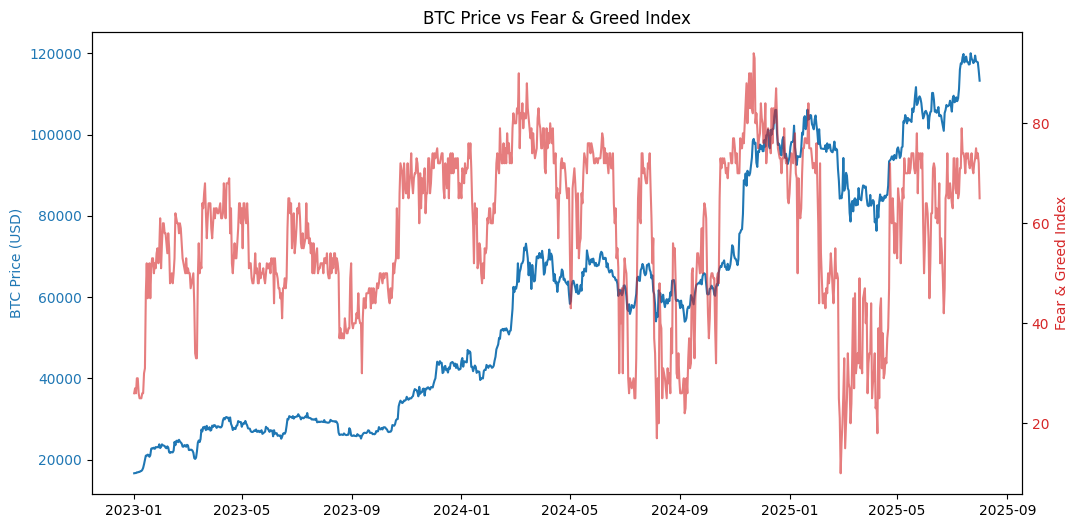

In [ ]:
# Cell 9️⃣: Visualization - kiểm tra nhanh

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_final["Date"], df_final["Close"], color='tab:blue', label="Price (Close)")
ax1.set_ylabel("BTC Price (USD)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Fear & Greed (chuẩn hóa thang 0–100)
if "fetch_fear_greed" in df_final.columns:
    ax2 = ax1.twinx()
    ax2.plot(df_final["Date"], df_final["fetch_fear_greed"], color='tab:red', alpha=0.6, label="Fear & Greed")
    ax2.set_ylabel("Fear & Greed Index", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f"{SYMBOL_BASE} Price vs Fear & Greed Index")
plt.show()


In [ ]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


📂 Đang đọc file mới nhất: dataset_BTC_20230101_20250801.csv
📏 944 dòng, 17 cột ban đầu
✅ Đã xử lý & lưu dữ liệu sạch:
- data\BTC\dataset_BTC_clean.csv
- data\BTC\dataset_BTC_clean.xlsx
📈 Tổng số dòng sau xử lý: 944



,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2023-01-01,16537.5,16618.8,16488.0,16610.3,105502.965,BTC,1.746450e+09,594299,0.000069,...,NaN,2.724834e+08,187516.000000,1.617335e+07,28.000000,1d,NaN,NaN,0.000000,26.800000
1,2023-01-02,16610.4,16799.0,16541.2,16666.0,215161.176,BTC,3.591354e+09,1020015,-0.000011,...,NaN,5.889606e+08,454811.269841,3.753554e+07,28.428571,1d,0.335334,0.003348,0.000539,27.571429
2,2023-01-03,16665.9,16774.0,16600.3,16667.2,203070.205,BTC,3.387369e+09,966813,0.000074,...,NaN,5.889606e+08,454811.269841,3.753554e+07,28.857143,1d,0.007200,0.000072,0.000550,27.142857
3,2023-01-04,16667.3,16984.6,16645.7,16842.1,349747.838,BTC,5.888327e+09,1618311,0.000049,...,NaN,2.423565e+08,277936.000000,1.551442e+07,29.285714,1d,1.049366,0.010439,0.002242,29.114286
4,2023-01-05,16842.2,16872.8,16740.4,16823.8,176369.347,BTC,2.966302e+09,892815,0.000057,...,NaN,5.889606e+08,454811.269841,3.753554e+07,29.714286,1d,-0.108656,-0.001087,0.002065,29.285714


In [ ]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


📂 Đang đọc file mới nhất: dataset_BTC_clean.csv
📏 944 dòng, 21 cột ban đầu
✅ Đã xử lý & lưu dữ liệu sạch:
- data\BTC\dataset_BTC_clean.csv
- data\BTC\dataset_BTC_clean.xlsx
📈 Tổng số dòng sau xử lý: 944



,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2023-01-01,16537.5,16618.8,16488.0,16610.3,105502.965,BTC,1.746450e+09,594299,0.000069,...,NaN,2.724834e+08,187516.000000,1.617335e+07,28.000000,1d,NaN,NaN,0.000000,26.800000
1,2023-01-02,16610.4,16799.0,16541.2,16666.0,215161.176,BTC,3.591354e+09,1020015,-0.000011,...,NaN,5.889606e+08,454811.269841,3.753554e+07,28.428571,1d,0.335334,0.003348,0.000539,27.571429
2,2023-01-03,16665.9,16774.0,16600.3,16667.2,203070.205,BTC,3.387369e+09,966813,0.000074,...,NaN,5.889606e+08,454811.269841,3.753554e+07,28.857143,1d,0.007200,0.000072,0.000550,27.142857
3,2023-01-04,16667.3,16984.6,16645.7,16842.1,349747.838,BTC,5.888327e+09,1618311,0.000049,...,NaN,2.423565e+08,277936.000000,1.551442e+07,29.285714,1d,1.049366,0.010439,0.002242,29.114286
4,2023-01-05,16842.2,16872.8,16740.4,16823.8,176369.347,BTC,2.966302e+09,892815,0.000057,...,NaN,5.889606e+08,454811.269841,3.753554e+07,29.714286,1d,-0.108656,-0.001087,0.002065,29.285714


## Lấy file dữ liệu XRP


In [ ]:
# Cell 1️⃣: Import & cấu hình cơ bản (phiên bản cố định, không cần nhập)
# -----------------------
# CONFIG CỐ ĐỊNH
# -----------------------

# Dữ liệu coin bạn muốn lấy
SYMBOL_BASE = "XRP"             # ví dụ: "BTC", "ETH", "BNB", "SOL", "XRP"
SYMBOL_BINANCE = SYMBOL_BASE + "USDT"   # tự tạo mã Binance Futures

# Thông tin thời gian
INTERVAL = "1d"                 # khung thời gian: "1d", "1h", ...
START_DATE = "2023-01-01"       # ngày bắt đầu
END_DATE = "2025-08-01"         # ngày kết thúc

# Thư mục lưu dữ liệu
OUT_DIR = os.path.join("data", SYMBOL_BASE)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"✅ Đang lấy dữ liệu cho {SYMBOL_BASE} ({SYMBOL_BINANCE}) từ {START_DATE} → {END_DATE}, interval={INTERVAL}")

✅ Đang lấy dữ liệu cho BTC (BTCUSDT) từ 2023-01-01 → 2025-08-01, interval=1d


In [ ]:
# Cell 2️⃣: Hàm xử lý thời gian (convert timestamp <-> datetime)

def dt_to_millis(dt: datetime):
    return int(dt.replace(tzinfo=timezone.utc).timestamp() * 1000)

def date_to_millis(s):
    dt = datetime.fromisoformat(s)
    return dt_to_millis(dt)

def millis_to_date(millis):
    return datetime.fromtimestamp(millis/1000, tz=timezone.utc).date()


In [ ]:
def fetch_binance_klines(symbol, interval, start_ts_ms, end_ts_ms):
    """
    Lấy dữ liệu OHLC từ Binance Futures (fallback sang Spot nếu bị chặn 418)
    """
    futures_url = "https://fapi.binance.com/fapi/v1/klines"
    spot_url = "https://api.binance.com/api/v3/klines"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    limit = 1000
    all_klines = []
    start = start_ts_ms
    use_spot = False

    while True:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start,
            "endTime": end_ts_ms,
            "limit": limit
        }

        # chọn API phù hợp
        url = spot_url if use_spot else futures_url
        try:
            r = requests.get(url, params=params, headers=headers, timeout=30)
            if r.status_code == 418:
                print(f"[WARN] Binance Futures chặn IP (418) → chuyển sang Spot API.")
                use_spot = True
                continue
            r.raise_for_status()
            data = r.json()
        except requests.exceptions.HTTPError as e:
            print(f"[ERROR] {e}")
            break
        except Exception as e:
            print(f"[WARN] Network error: {e}")
            time.sleep(5)
            continue

        if not data:
            break

        all_klines.extend(data)
        if len(data) < limit:
            break
        last_open = data[-1][0]
        start = last_open + 1
        time.sleep(0.2)

    # Chuyển sang DataFrame
    if not all_klines:
        print("[WARN] Không lấy được dữ liệu Klines.")
        return pd.DataFrame(columns=["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades","symbol"])

    cols = ["open_time","open","high","low","close","volume","close_time",
            "quote_asset_volume","num_trades","taker_buy_base_vol","taker_buy_quote_vol","ignore"]

    df = pd.DataFrame(all_klines, columns=cols)
    df["Date"] = pd.to_datetime(df["open_time"], unit="ms", utc=True).dt.date
    df = df[["Date","open","high","low","close","volume","quote_asset_volume","num_trades"]]
    df.columns = ["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]
    for c in ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["symbol"] = SYMBOL_BASE
    df = df.sort_values("Date").drop_duplicates("Date").reset_index(drop=True)

    print(f"✅ Dữ liệu Binance ({'Spot' if use_spot else 'Futures'}) tải thành công: {len(df)} dòng")
    return df


In [ ]:
# Cell 4️⃣: Funding Rate trung bình theo ngày (Binance Futures)

def fetch_binance_funding(symbol, start_ts_ms, end_ts_ms):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    limit = 1000
    all_rows = []
    start = start_ts_ms

    while True:
        params = {"symbol": symbol, "startTime": start, "endTime": end_ts_ms, "limit": limit}
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        if not data:
            break

        all_rows.extend(data)
        if len(data) < limit:
            break

        last_t = data[-1]["fundingTime"]
        start = last_t + 1
        time.sleep(0.2)

    if not all_rows:
        return pd.DataFrame(columns=["Date","funding_Rate"])

    df = pd.DataFrame(all_rows)
    df["fundingTime"] = pd.to_datetime(df["fundingTime"], unit="ms", utc=True)
    df["Date"] = df["fundingTime"].dt.date
    df["fundingRate"] = pd.to_numeric(df["fundingRate"], errors="coerce")
    daily = df.groupby("Date", as_index=False)["fundingRate"].mean().rename(columns={"fundingRate":"funding_Rate"})
    return daily

In [ ]:
# Cell 5️⃣: Lấy Fear & Greed Index (Alternative.me API) — phiên bản ổn định nhất

def fetch_fear_greed(limit=0):
    """
    Lấy dữ liệu Fear & Greed Index từ API alternative.me
    Trả về DataFrame có cột: Date, fetch_fear_greed
    """
    url = "https://api.alternative.me/fng/"
    params = {"limit": limit, "format": "json"}  # không dùng date_format vì không cần thiết

    try:
        r = requests.get(url, params=params, timeout=15)
        r.raise_for_status()
        j = r.json()
        data = j.get("data", [])
    except Exception as e:
        print(f"[WARN] Fear & Greed API failed: {e}")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    # Nếu rỗng, in cảnh báo
    if not data:
        print("[WARN] Fear & Greed API returned empty dataset, skipping...")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    rows = []
    for entry in data:
        try:
            ts = int(entry["timestamp"])
            value = float(entry["value"])
            date = datetime.fromtimestamp(ts, tz=timezone.utc).date()
            rows.append({"Date": date, "fetch_fear_greed": value})
        except Exception as e:
            print(f"[WARN] parse error: {e}")
            continue

    df = pd.DataFrame(rows)
    df = df.drop_duplicates("Date").sort_values("Date").reset_index(drop=True)
    print(f"✅ Fear & Greed fetched: {len(df)} rows")
    print(df.head())
    return df

In [ ]:
# Cell 6️⃣: On-chain metrics (active_addresses, hash_rate, tx_count, miners_revenue)

BLOCKCHAIN_CHARTS = {
    # "active_addresses": "n-active-addresses",  # ⚠️ gỡ bỏ vì bị 404
    "hash_rate": "hash-rate",
    "tx_count": "n-transactions",
    "miners_revenue": "miners-revenue"
}


def fetch_blockchain_chart(chart_name, timespan_days=4000):
    url = f"https://api.blockchain.info/charts/{chart_name}"
    params = {"timespan": f"{timespan_days}days", "format":"json", "sampled":False}
    r = requests.get(url, params=params, timeout=30)
    if r.status_code != 200:
        r = requests.get(url, params={"timespan":f"{timespan_days}days","format":"json"}, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f"Blockchain.info chart {chart_name} returned {r.status_code}")

    j = r.json()
    values = j.get("values", [])
    rows = [{"Date": datetime.fromtimestamp(v["x"], tz=timezone.utc).date(), chart_name: v["y"]} for v in values]
    return pd.DataFrame(rows).drop_duplicates("Date").sort_values("Date").reset_index(drop=True)

def fetch_onchain_from_blockchain_info(mapping):
    dfs = []
    for outcol, chart in mapping.items():
        try:
            dfc = fetch_blockchain_chart(chart, timespan_days=5000)
            dfc = dfc.rename(columns={chart: outcol})
            dfs.append(dfc)
            time.sleep(0.2)
        except Exception as e:
            print(f"[WARN] Could not fetch chart {chart}: {e}")
    if not dfs:
        return pd.DataFrame(columns=["Date"])
    df_merged = dfs[0]
    for d in dfs[1:]:
        df_merged = pd.merge(df_merged, d, on="Date", how="outer")
    return df_merged.sort_values("Date").reset_index(drop=True)

In [ ]:
# Cell 6️⃣b: Lấy dữ liệu Google Trends (Interest Over Time) - có delay và fallback

def fetch_google_trend(symbol_base: str, start_date: str, end_date: str):
    """
    Lấy độ quan tâm Google Trends (Interest Over Time)
    Có delay tránh 429, và fallback từ file local nếu API bị chặn.
    """
    kw = symbol_base.lower()
    if kw == "btc": kw = "bitcoin"
    elif kw == "eth": kw = "ethereum"

    local_path = os.path.join("data", symbol_base, f"google_trend_{symbol_base}.csv")

    # Nếu có file cũ thì đọc lại
    if os.path.exists(local_path):
        print(f"📂 Đọc cache Google Trends từ {local_path}")
        df_cached = pd.read_csv(local_path)
        df_cached["Date"] = pd.to_datetime(df_cached["Date"]).dt.date
        return df_cached

    # Nếu chưa có cache -> gọi API
    time.sleep(random.uniform(10, 20))
    pytrends = TrendReq(hl='en-US', tz=0)
    timeframe = f"{start_date} {end_date}"
    try:
        pytrends.build_payload([kw], timeframe=timeframe)
        df_trend = pytrends.interest_over_time()
    except Exception as e:
        print(f"[WARN] Pytrends failed: {e}")
        return pd.DataFrame(columns=["Date", "google_interest"])

    if df_trend.empty:
        print("[WARN] Pytrends returned empty data.")
        return pd.DataFrame(columns=["Date", "google_interest"])

    df_trend = df_trend.reset_index()
    df_trend["Date"] = df_trend["date"].dt.date
    df_trend = df_trend.rename(columns={kw: "google_interest"})
    df_trend = df_trend[["Date", "google_interest"]]

    # Lưu cache
    df_trend.to_csv(local_path, index=False)
    print(f"✅ Lưu cache: {local_path}")
    return df_trend

In [ ]:
# Cell 7️⃣ (cập nhật thêm pytrends)

def build_dataset():
    start_ts = date_to_millis(START_DATE)
    end_dt = datetime.fromisoformat(END_DATE)
    end_of_day = datetime(end_dt.year, end_dt.month, end_dt.day, 23, 59, 59, tzinfo=timezone.utc)
    end_ts = int(end_of_day.timestamp() * 1000)

    print("Fetching klines from Binance futures...")
    df_klines = fetch_binance_klines(SYMBOL_BINANCE, INTERVAL, start_ts, end_ts)
    print(f"klines rows: {len(df_klines)}")

    print("Fetching funding rates...")
    df_fund = fetch_binance_funding(SYMBOL_BINANCE, start_ts, end_ts)
    print(f"funding rows: {len(df_fund)}")

    print("Fetching Fear & Greed index...")
    df_fng = fetch_fear_greed(limit=0)
    print(f"fear&greed rows: {len(df_fng)}")

    print("Fetching on-chain metrics...")
    df_onchain = fetch_onchain_from_blockchain_info(BLOCKCHAIN_CHARTS)
    print(f"onchain rows: {len(df_onchain)}")

    # 🔍 Thêm phần Google Trends
    print("Fetching Google Trends interest...")
    df_trend = fetch_google_trend(SYMBOL_BASE, START_DATE, END_DATE)

    # Merge các bảng
    df = df_klines.copy()
    df = pd.merge(df, df_fund, on="Date", how="left")
    df = pd.merge(df, df_fng, on="Date", how="left")
    df = pd.merge(df, df_onchain, on="Date", how="left")
    df = pd.merge(df, df_trend, on="Date", how="left")  # 🔍 thêm dòng này

    # Bổ sung cột thiếu
    for col in ["funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]:
        if col not in df.columns:
            df[col] = pd.NA

    df["time_frame"] = INTERVAL

    # Thứ tự cột cuối cùng
    final_cols = ["Date","Open","High","Low","Close","Volume","symbol",
                  "Quote_Volume","Number_Of_Trades","funding_Rate","fetch_fear_greed",
                  "active_addresses","hash_rate","tx_count","miners_revenue",
                  "google_interest","time_frame"]

    df = df[[c for c in final_cols if c in df.columns]]

    # Xuất file
    start_tag = datetime.fromisoformat(START_DATE).strftime("%Y%m%d")
    end_tag = end_dt.strftime("%Y%m%d")
    out_csv = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.csv")
    out_xlsx = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.xlsx")

    df.to_csv(out_csv, index=False)
    df.to_excel(out_xlsx, index=False)
    print(f"✅ Saved CSV: {out_csv}")
    print(f"✅ Saved XLSX: {out_xlsx}")

    return df

In [ ]:
# Cell 8️⃣: Chạy chính
df_final = build_dataset()
print("\n✅ Hoàn tất! Xem 10 dòng đầu:")
df_final.head(10)

Fetching klines from Binance futures...
✅ Dữ liệu Binance (Futures) tải thành công: 944 dòng
klines rows: 944
Fetching funding rates...
funding rows: 944
Fetching Fear & Greed index...
✅ Fear & Greed fetched: 2823 rows
         Date  fetch_fear_greed
0  2018-02-01              30.0
1  2018-02-02              15.0
2  2018-02-03              40.0
3  2018-02-04              24.0
4  2018-02-05              11.0
fear&greed rows: 2823
Fetching on-chain metrics...
onchain rows: 1667
Fetching Google Trends interest...
📂 Đọc cache Google Trends từ data\BTC\google_trend_BTC.csv
✅ Saved CSV: data\BTC\dataset_BTC_20230101_20250801.csv
✅ Saved XLSX: data\BTC\dataset_BTC_20230101_20250801.xlsx

✅ Hoàn tất! Xem 10 dòng đầu:


,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,fetch_fear_greed,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame
0,2023-01-01,16537.5,16618.8,16488.0,16610.3,105502.965,BTC,1.746450e+09,594299,0.000069,26.0,<NA>,2.724834e+08,187516.0,1.617335e+07,28.0,1d
1,2023-01-02,16610.4,16799.0,16541.2,16666.0,215161.176,BTC,3.591354e+09,1020015,-0.000011,27.0,<NA>,NaN,NaN,NaN,NaN,1d
2,2023-01-03,16665.9,16774.0,16600.3,16667.2,203070.205,BTC,3.387369e+09,966813,0.000074,26.0,<NA>,NaN,NaN,NaN,NaN,1d
3,2023-01-04,16667.3,16984.6,16645.7,16842.1,349747.838,BTC,5.888327e+09,1618311,0.000049,29.0,<NA>,2.423565e+08,277936.0,1.551442e+07,NaN,1d
4,2023-01-05,16842.2,16872.8,16740.4,16823.8,176369.347,BTC,2.966302e+09,892815,0.000057,29.0,<NA>,NaN,NaN,NaN,NaN,1d
5,2023-01-06,16823.8,17030.0,16664.8,16943.8,316973.629,BTC,5.333655e+09,1370628,0.000069,26.0,<NA>,NaN,NaN,NaN,NaN,1d
6,2023-01-07,16943.9,16973.6,16900.1,16936.5,77973.105,BTC,1.320073e+09,454642,0.000044,25.0,<NA>,2.609993e+08,246679.0,1.666961e+07,NaN,1d
7,2023-01-08,16936.5,17181.1,16905.0,17124.7,157717.318,BTC,2.677203e+09,775585,0.000077,25.0,<NA>,NaN,NaN,NaN,31.0,1d
8,2023-01-09,17124.6,17387.8,17098.2,17169.7,400277.809,BTC,6.899177e+09,1767631,0.000020,25.0,<NA>,NaN,NaN,NaN,NaN,1d
9,2023-01-10,17169.6,17485.4,17140.4,17428.8,297320.371,BTC,5.146869e+09,1362100,0.000051,26.0,<NA>,2.864213e+08,302809.0,1.867144e+07,NaN,1d


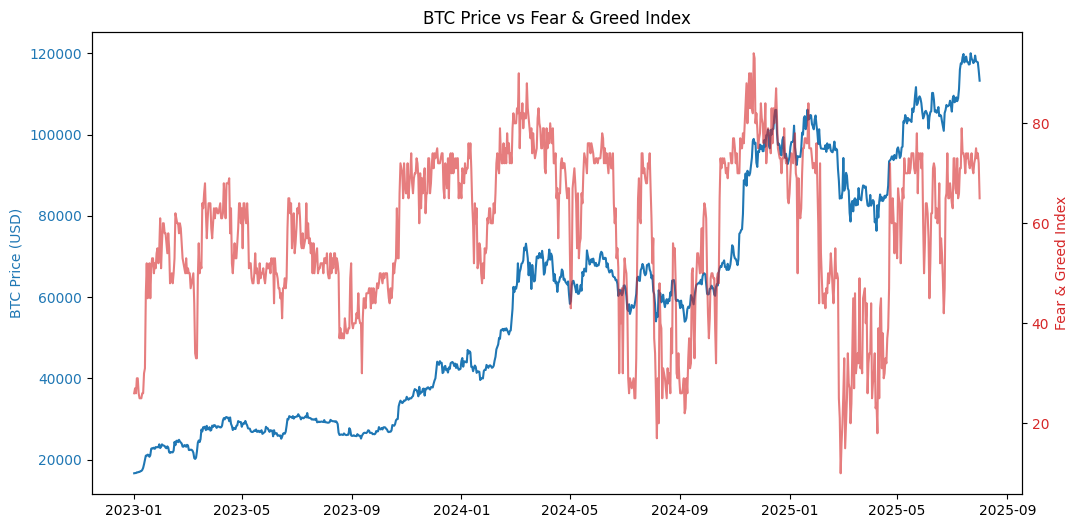

In [ ]:
# Cell 9️⃣: Visualization - kiểm tra nhanh

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_final["Date"], df_final["Close"], color='tab:blue', label="Price (Close)")
ax1.set_ylabel("BTC Price (USD)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Fear & Greed (chuẩn hóa thang 0–100)
if "fetch_fear_greed" in df_final.columns:
    ax2 = ax1.twinx()
    ax2.plot(df_final["Date"], df_final["fetch_fear_greed"], color='tab:red', alpha=0.6, label="Fear & Greed")
    ax2.set_ylabel("Fear & Greed Index", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f"{SYMBOL_BASE} Price vs Fear & Greed Index")
plt.show()


In [ ]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


📂 Đang đọc file mới nhất: dataset_BTC_20230101_20250801.csv
📏 944 dòng, 17 cột ban đầu
✅ Đã xử lý & lưu dữ liệu sạch:
- data\BTC\dataset_BTC_clean.csv
- data\BTC\dataset_BTC_clean.xlsx
📈 Tổng số dòng sau xử lý: 944



,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2023-01-01,16537.5,16618.8,16488.0,16610.3,105502.965,BTC,1.746450e+09,594299,0.000069,...,NaN,2.724834e+08,187516.000000,1.617335e+07,28.000000,1d,NaN,NaN,0.000000,26.800000
1,2023-01-02,16610.4,16799.0,16541.2,16666.0,215161.176,BTC,3.591354e+09,1020015,-0.000011,...,NaN,5.889606e+08,454811.269841,3.753554e+07,28.428571,1d,0.335334,0.003348,0.000539,27.571429
2,2023-01-03,16665.9,16774.0,16600.3,16667.2,203070.205,BTC,3.387369e+09,966813,0.000074,...,NaN,5.889606e+08,454811.269841,3.753554e+07,28.857143,1d,0.007200,0.000072,0.000550,27.142857
3,2023-01-04,16667.3,16984.6,16645.7,16842.1,349747.838,BTC,5.888327e+09,1618311,0.000049,...,NaN,2.423565e+08,277936.000000,1.551442e+07,29.285714,1d,1.049366,0.010439,0.002242,29.114286
4,2023-01-05,16842.2,16872.8,16740.4,16823.8,176369.347,BTC,2.966302e+09,892815,0.000057,...,NaN,5.889606e+08,454811.269841,3.753554e+07,29.714286,1d,-0.108656,-0.001087,0.002065,29.285714


In [ ]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


📂 Đang đọc file mới nhất: dataset_BTC_clean.csv
📏 944 dòng, 21 cột ban đầu
✅ Đã xử lý & lưu dữ liệu sạch:
- data\BTC\dataset_BTC_clean.csv
- data\BTC\dataset_BTC_clean.xlsx
📈 Tổng số dòng sau xử lý: 944



,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2023-01-01,16537.5,16618.8,16488.0,16610.3,105502.965,BTC,1.746450e+09,594299,0.000069,...,NaN,2.724834e+08,187516.000000,1.617335e+07,28.000000,1d,NaN,NaN,0.000000,26.800000
1,2023-01-02,16610.4,16799.0,16541.2,16666.0,215161.176,BTC,3.591354e+09,1020015,-0.000011,...,NaN,5.889606e+08,454811.269841,3.753554e+07,28.428571,1d,0.335334,0.003348,0.000539,27.571429
2,2023-01-03,16665.9,16774.0,16600.3,16667.2,203070.205,BTC,3.387369e+09,966813,0.000074,...,NaN,5.889606e+08,454811.269841,3.753554e+07,28.857143,1d,0.007200,0.000072,0.000550,27.142857
3,2023-01-04,16667.3,16984.6,16645.7,16842.1,349747.838,BTC,5.888327e+09,1618311,0.000049,...,NaN,2.423565e+08,277936.000000,1.551442e+07,29.285714,1d,1.049366,0.010439,0.002242,29.114286
4,2023-01-05,16842.2,16872.8,16740.4,16823.8,176369.347,BTC,2.966302e+09,892815,0.000057,...,NaN,5.889606e+08,454811.269841,3.753554e+07,29.714286,1d,-0.108656,-0.001087,0.002065,29.285714


# Gộp các dữ liệu lại.

In [ ]:
coin_list = ["BTC", "ETH", "BNB", "SOL", "XRP"]   # ⚙️ Thêm hoặc bớt coin tùy bạn
# ví dụ: "BTC", "ETH", "BNB", "SOL", "XRP"

In [ ]:
# Cell 1️⃣1️⃣: Gộp tất cả dataset _clean thành 1 file tổng trong thư mục data/

def combine_clean_datasets(coin_list):
    """
    Gộp các file _clean.csv của danh sách coin thành 1 DataFrame lớn.
    Lưu file tổng ngay trong thư mục 'data/'.
    """
    all_dfs = []

    for coin in coin_list:
        data_dir = os.path.join("data", coin)
        clean_files = glob.glob(os.path.join(data_dir, f"dataset_{coin}_clean.csv"))

        if not clean_files:
            print(f"⚠️ Không tìm thấy file clean cho {coin}")
            continue

        latest_file = sorted(clean_files, key=os.path.getmtime)[-1]
        print(f"📂 Đang đọc: {os.path.basename(latest_file)}")
        df = pd.read_csv(latest_file)

        # Bổ sung cột symbol nếu thiếu
        if "symbol" not in df.columns:
            df["symbol"] = coin

        all_dfs.append(df)
        print(f"✅ {coin}: {df.shape[0]} dòng, {df.shape[1]} cột")

    if not all_dfs:
        print("❌ Không có file nào để gộp.")
        return None

    # Gộp & sắp xếp
    df_total = pd.concat(all_dfs, ignore_index=True)
    df_total = df_total.sort_values(["symbol", "Date"]).reset_index(drop=True)

    print(f"\n📊 Tổng cộng {df_total.shape[0]} dòng từ {len(all_dfs)} đồng coin.")
    print(f"📈 Các đồng được gộp: {', '.join(coin_list)}")

    # Xuất file tổng trong thư mục data/
    out_csv = os.path.join("data", "dataset_total_clean.csv")
    out_xlsx = os.path.join("data", "dataset_total_clean.xlsx")

    df_total.to_csv(out_csv, index=False)
    df_total.to_excel(out_xlsx, index=False)

    print(f"💾 Đã lưu file tổng:\n- {out_csv}\n- {out_xlsx}")
    return df_total


# --- Chạy chính ---
df_total = combine_clean_datasets(coin_list)
df_total.head()


📂 Đang đọc: dataset_BTC_clean.csv
✅ BTC: 944 dòng, 21 cột
📂 Đang đọc: dataset_ETH_clean.csv
✅ ETH: 944 dòng, 21 cột
📂 Đang đọc: dataset_BNB_clean.csv
✅ BNB: 944 dòng, 21 cột
📂 Đang đọc: dataset_SOL_clean.csv
✅ SOL: 944 dòng, 21 cột
📂 Đang đọc: dataset_XRP_clean.csv
✅ XRP: 944 dòng, 21 cột

📊 Tổng cộng 4720 dòng từ 5 đồng coin.
📈 Các đồng được gộp: BTC, ETH, BNB, SOL, XRP
💾 Đã lưu file tổng:
- data\dataset_total_clean.csv
- data\dataset_total_clean.xlsx


,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2023-01-01,246.11,246.59,243.25,244.36,793153.38,BNB,1.939856e+08,246426,-0.000003,...,NaN,5.861378e+08,460136.752381,3.753786e+07,76.000000,1d,NaN,NaN,0.061094,46.000000
1,2023-01-02,244.35,247.88,240.40,245.07,1476135.06,BNB,3.620143e+08,407787,-0.000025,...,NaN,2.742413e+08,229347.000000,1.644734e+07,75.857143,1d,0.290555,0.002901,0.062204,46.542857
2,2023-01-03,245.06,246.90,244.02,245.97,917619.33,BNB,2.252540e+08,287346,-0.000052,...,NaN,5.861378e+08,460136.752381,3.753786e+07,75.714286,1d,0.367242,0.003666,0.063611,45.885714
3,2023-01-04,245.97,260.90,245.47,258.54,2601842.57,BNB,6.647247e+08,747686,0.000000,...,NaN,5.861378e+08,460136.752381,3.753786e+07,75.571429,1d,5.110379,0.049841,0.083267,47.628571
4,2023-01-05,258.55,258.90,255.00,256.44,1016972.84,BNB,2.612803e+08,344953,-0.000396,...,NaN,2.660837e+08,279391.000000,1.719090e+07,75.428571,1d,-0.812253,-0.008156,0.079983,47.571429


In [ ]:
# Cell 1️⃣1️⃣b: Đổi tên các cột cho đồng nhất & dễ đọc

import os
import pandas as pd

# 🔧 Đường dẫn file tổng hiện tại (có thể đổi nếu cần)
file_path = "data/dataset_total_clean.csv"

# Đọc dữ liệu
df = pd.read_csv(file_path)
print(f"📂 Đã đọc file: {file_path}")
print(f"📏 Trước đổi tên: {df.shape[1]} cột")

# 🧩 Đổi tên các cột mong muốn
rename_map = {
    "fetch_fear_greed": "fear_greed_index",
    "google_interest": "google_trend_score",
    "Close_norm": "close_norm",
    "active_addresses": "onchain_active_addresses"
}

# Chỉ đổi nếu cột tồn tại
existing = [c for c in rename_map.keys() if c in df.columns]
df = df.rename(columns={k: rename_map[k] for k in existing})

print(f"✅ Đã đổi tên {len(existing)} cột:")
for old, new in rename_map.items():
    if old in existing:
        print(f"   • {old} → {new}")

# 💾 Lưu lại — bạn có thể chọn:
SAVE_OVERWRITE = True   # ⚙️ Đổi thành False nếu muốn lưu bản mới

if SAVE_OVERWRITE:
    out_csv = file_path
    out_xlsx = "data/dataset_total_clean.xlsx"
else:
    out_csv = "data/dataset_total_clean_renamed.csv"
    out_xlsx = "data/dataset_total_clean_renamed.xlsx"

df.to_csv(out_csv, index=False)
df.to_excel(out_xlsx, index=False)

print(f"💾 Đã lưu lại:\n- {out_csv}\n- {out_xlsx}")
print("\n📑 Danh sách cột sau khi đổi tên:")
print(df.columns.tolist()[:15], "...")


📂 Đã đọc file: data/dataset_total_clean.csv
📏 Trước đổi tên: 21 cột
✅ Đã đổi tên 4 cột:
   • fetch_fear_greed → fear_greed_index
   • google_interest → google_trend_score
   • Close_norm → close_norm
   • active_addresses → onchain_active_addresses
💾 Đã lưu lại:
- data/dataset_total_clean.csv
- data/dataset_total_clean.xlsx

📑 Danh sách cột sau khi đổi tên:
['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'symbol', 'Quote_Volume', 'Number_Of_Trades', 'funding_Rate', 'fear_greed_index', 'onchain_active_addresses', 'hash_rate', 'tx_count', 'miners_revenue'] ...


In [ ]:
#Kiểm tra trùng lặp logic
df.duplicated(['Date','symbol']).sum()


if 'onchain_active_addresses' in df.columns:
    df = df.drop(columns=['onchain_active_addresses'])
    print("✅ Đã xoá cột 'onchain_active_addresses' khỏi dataset.")
else:
    print("⚠️ Không tìm thấy cột 'onchain_active_addresses'.")


✅ Đã xoá cột 'onchain_active_addresses' khỏi dataset.
